# Installing libraries and loading data

In [ ]:
!pip install umap-learn --quiet

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"menashelorenzi","key":"576a41e385673bc2cc30b2f833f51125"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d jessemostipak/hotel-booking-demand


Dataset URL: https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand
License(s): Attribution 4.0 International (CC BY 4.0)


In [ ]:
import zipfile

with zipfile.ZipFile("hotel-booking-demand.zip", 'r') as zip_ref:
    zip_ref.extractall("hotel_booking_data")


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA, FastICA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.metrics import silhouette_score, mutual_info_score, normalized_mutual_info_score, adjusted_rand_score
from sklearn.manifold import TSNE, Isomap
from sklearn.feature_selection import mutual_info_classif
import umap.umap_ as umap
from sklearn.mixture import GaussianMixture
from IPython.display import display
from scipy.stats import chi2_contingency, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd


#0 - Creating a Dataset

In [ ]:
df_full = pd.read_csv("hotel_booking_data/hotel_bookings.csv")

sample_df = df_full.sample(n=20000, random_state=42).reset_index(drop=True)
sample_df.to_csv('sample_data.csv', index=False)
print(sample_df.shape)
print(sample_df.head(3))

(20000, 32)
          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        203               2016           December   
1    City Hotel            1         82               2015               July   
2    City Hotel            0         25               2016           December   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        49                          2   
1                        29                         16   
2                        53                         27   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        2                     5       2  ...    No Deposit   
1                        0                     3       2  ...    No Deposit   
2                        0                     3       3  ...    No Deposit   

   agent company days_in_waiting_list    customer_type   adr  \
0  250.0     NaN                    0        Tran

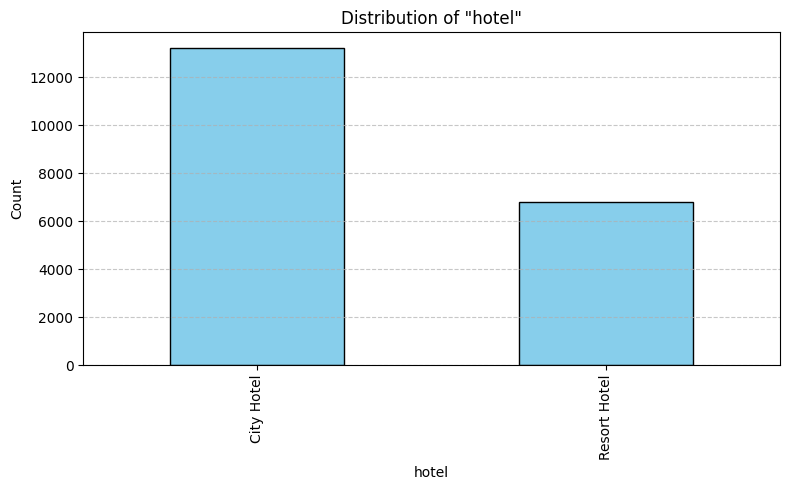

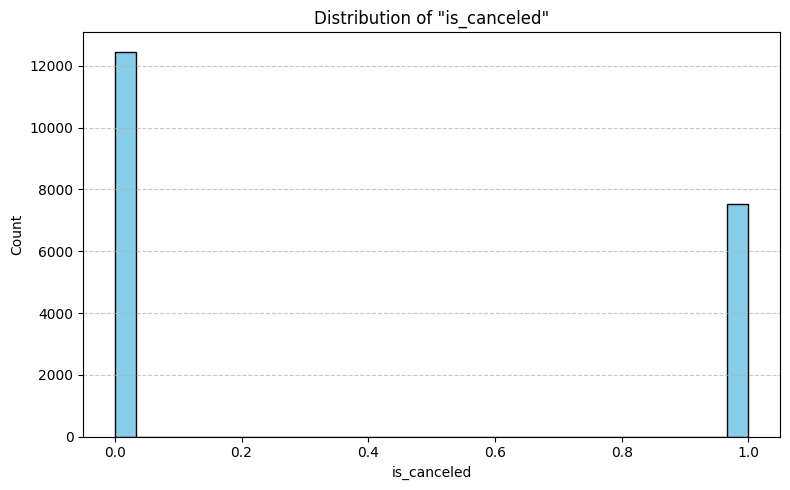

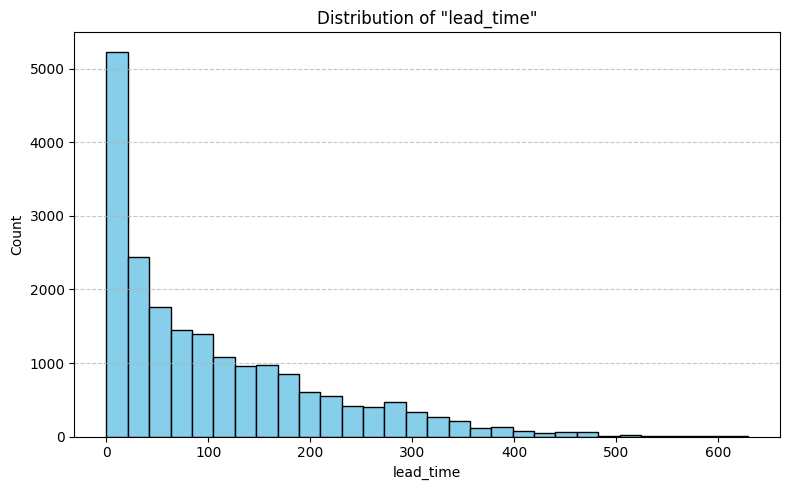

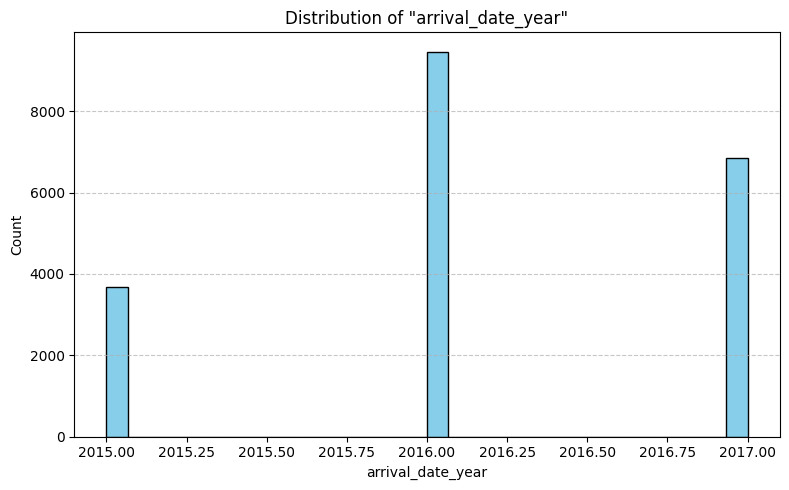

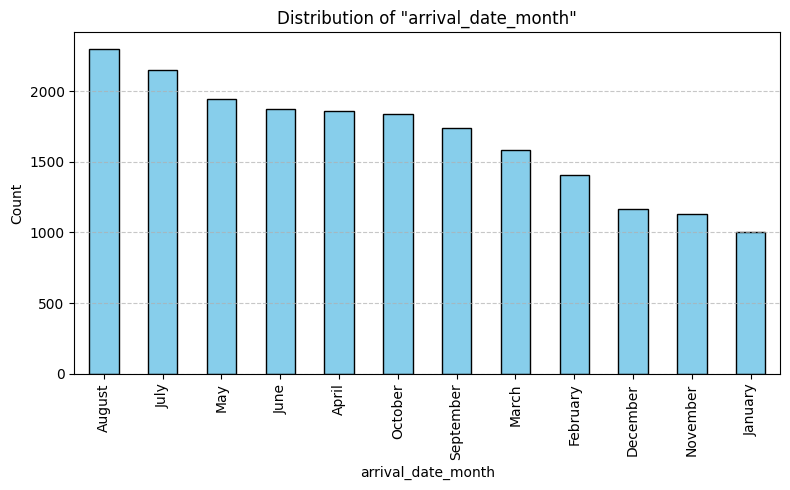

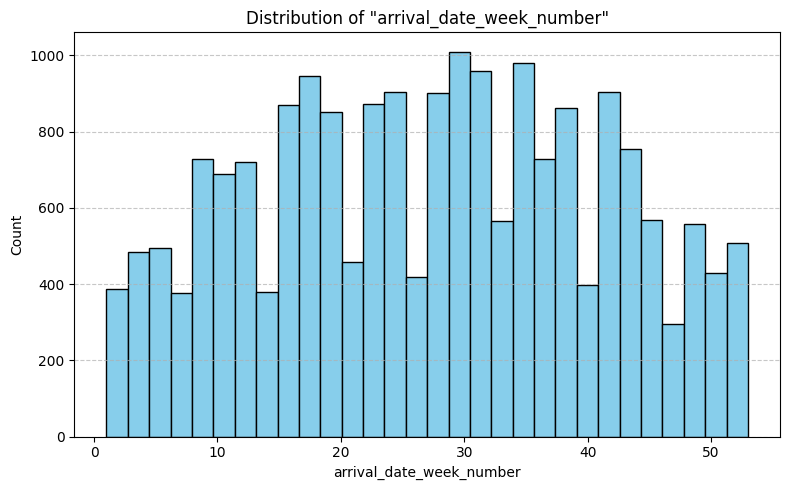

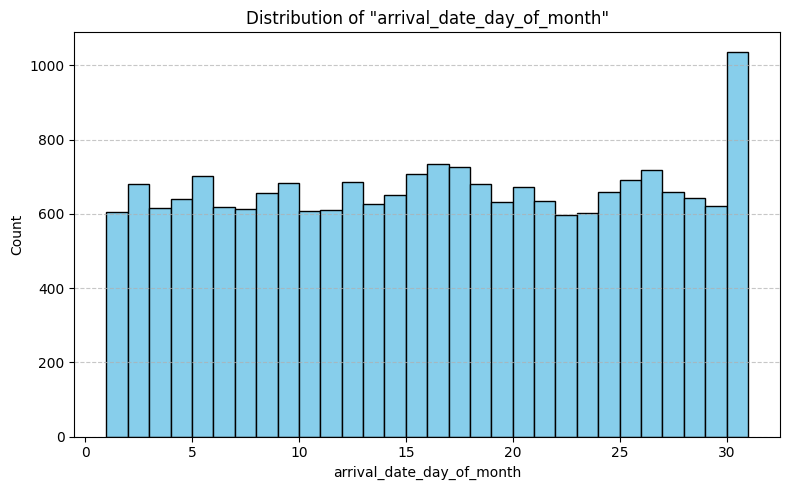

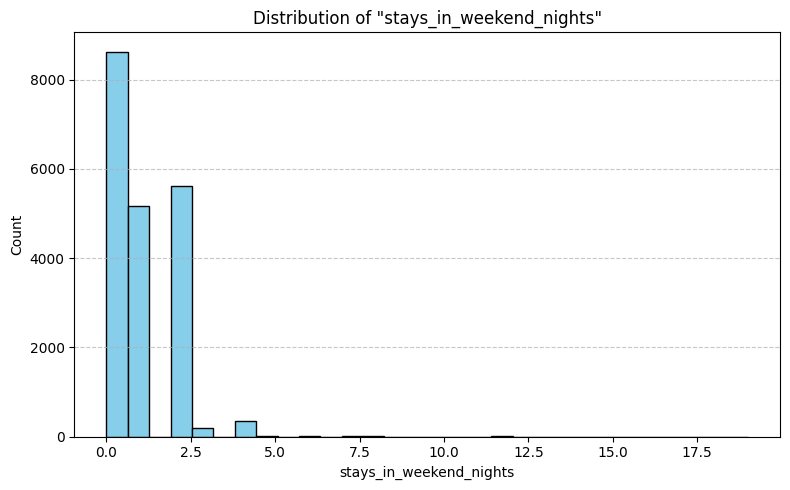

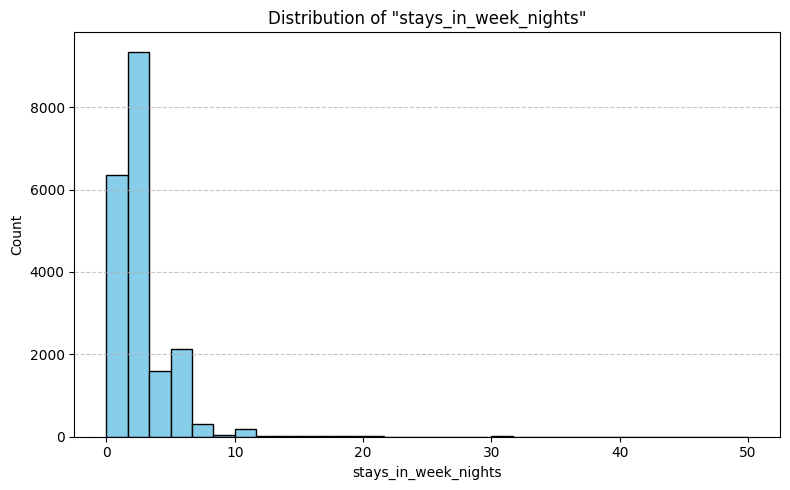

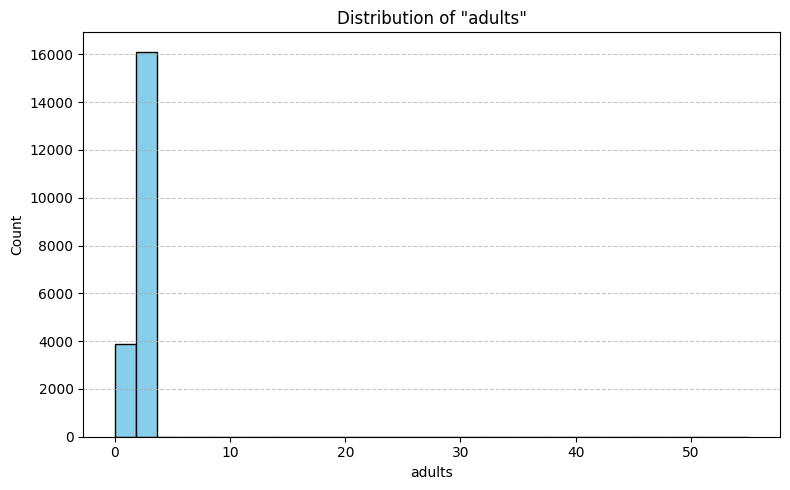

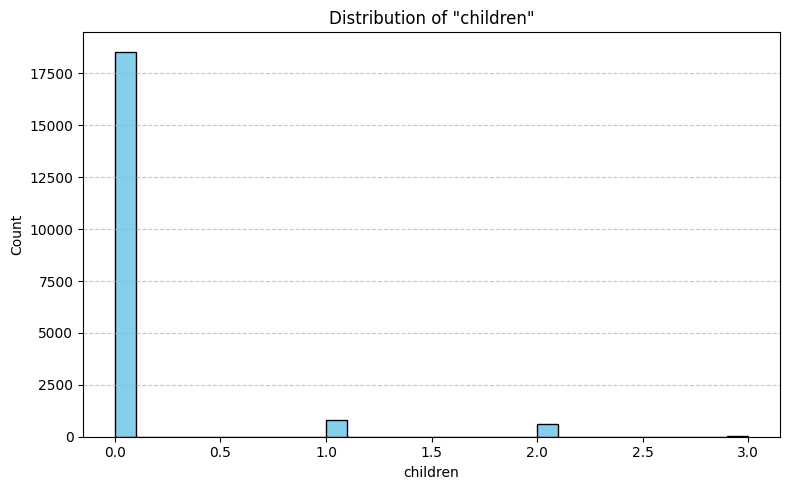

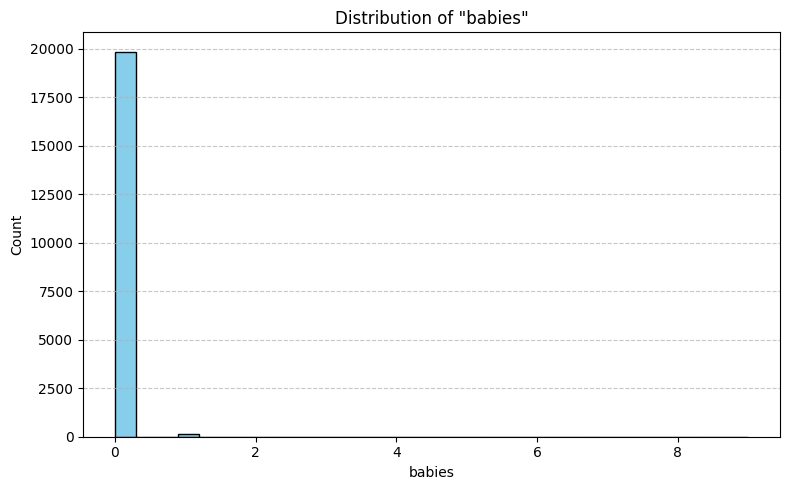

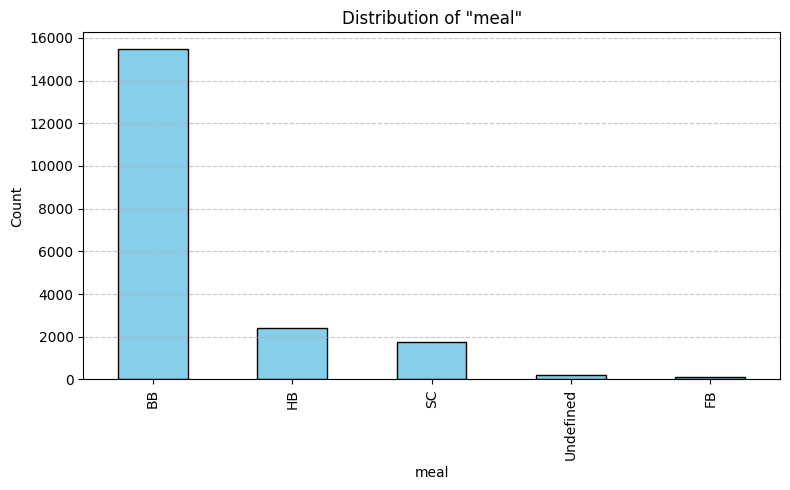

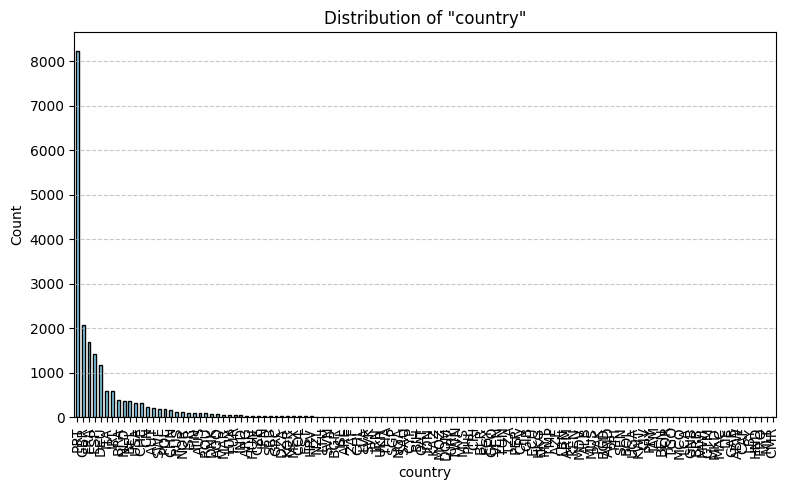

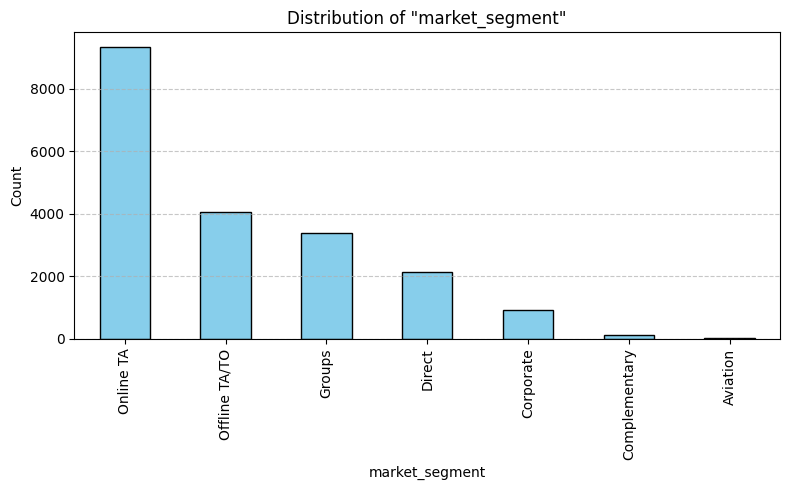

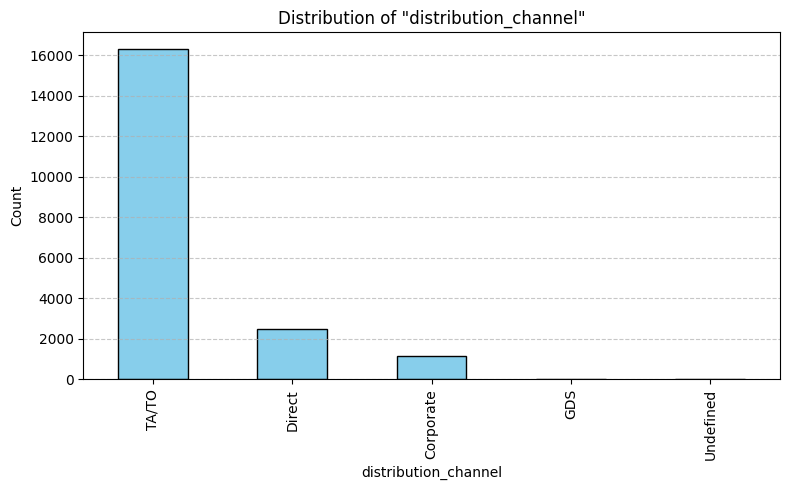

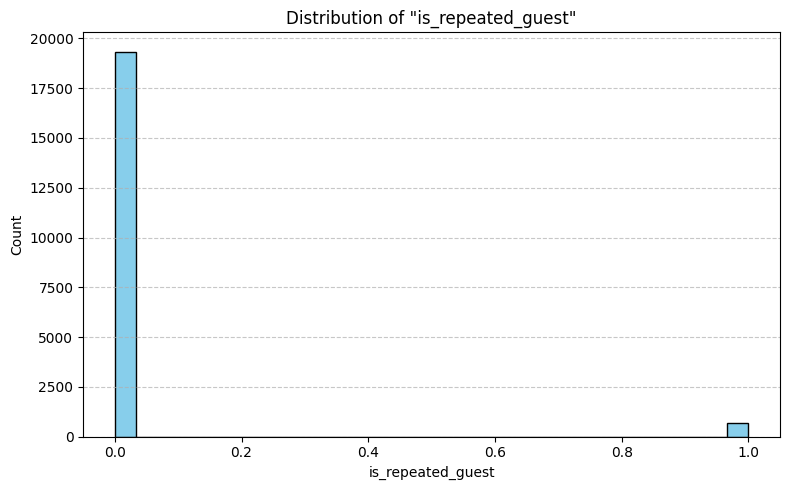

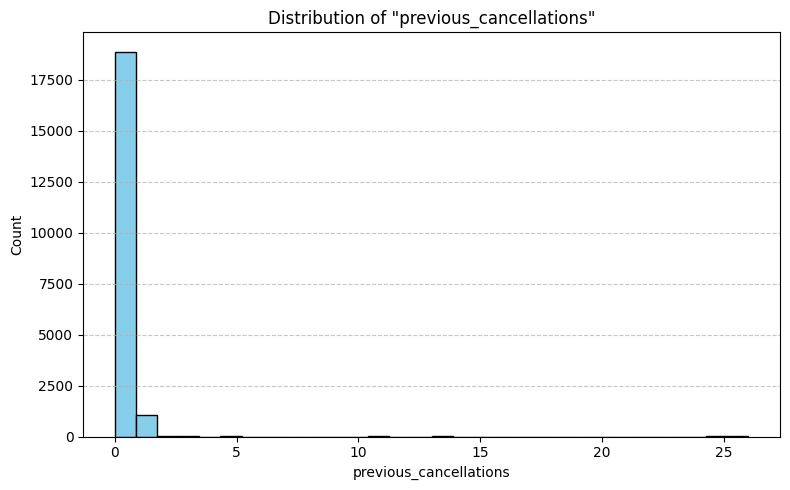

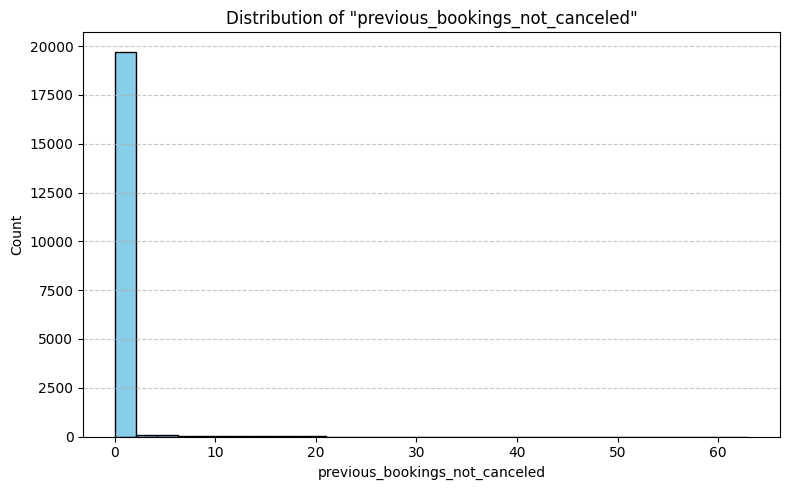

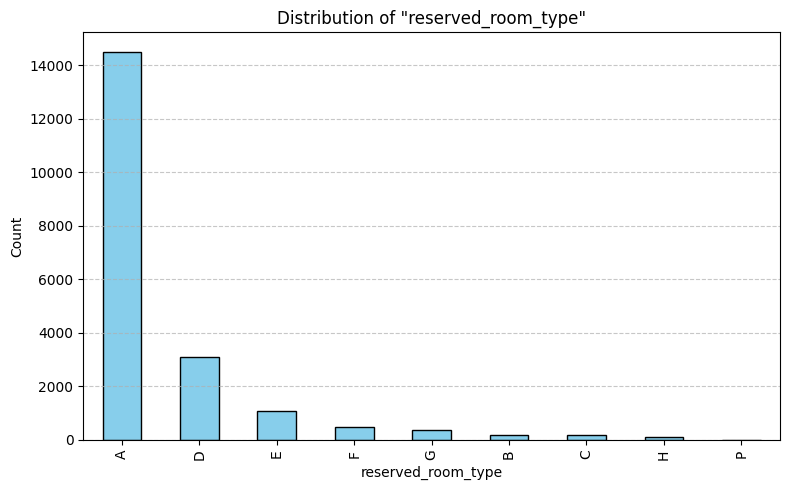

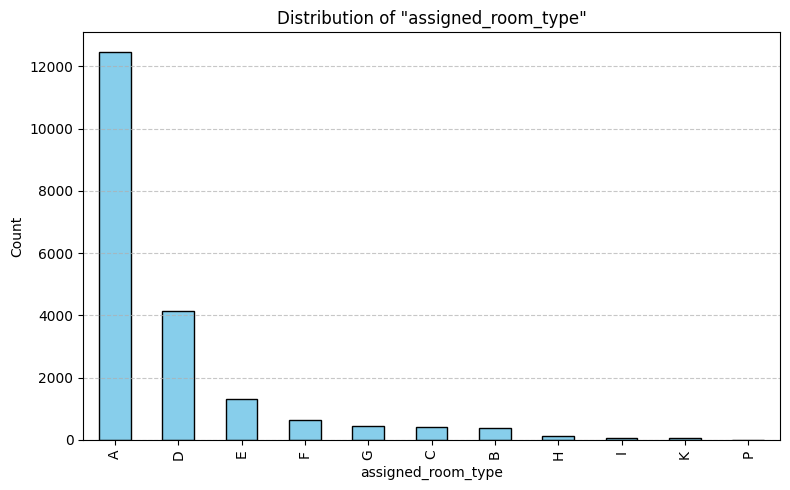

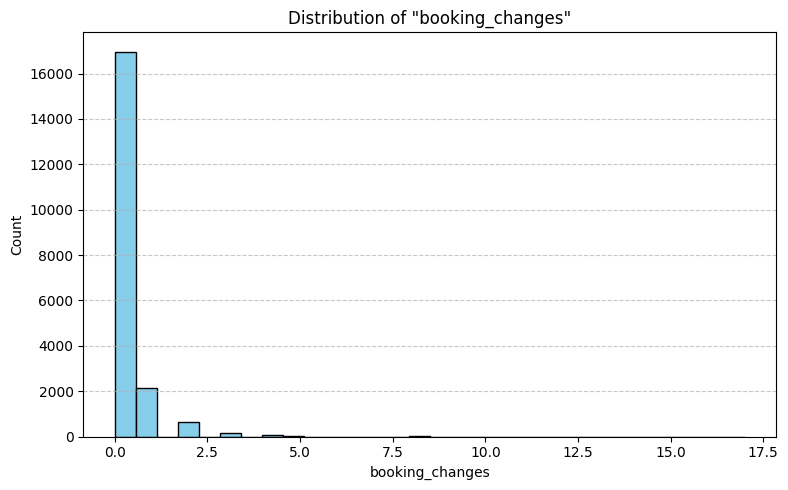

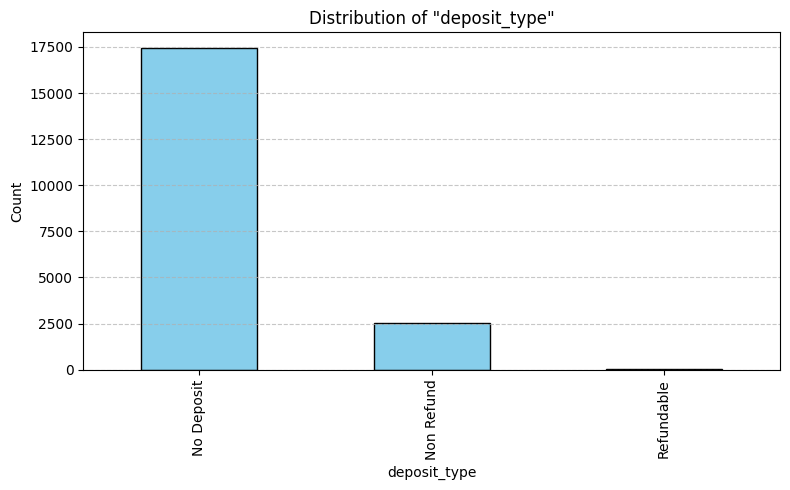

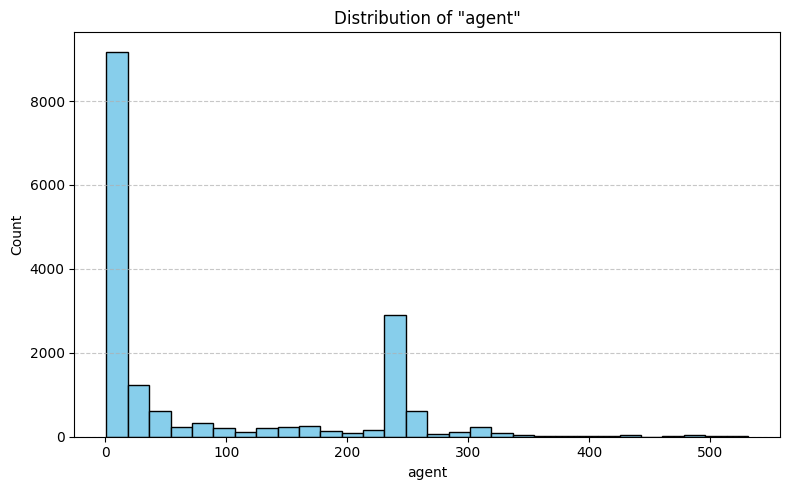

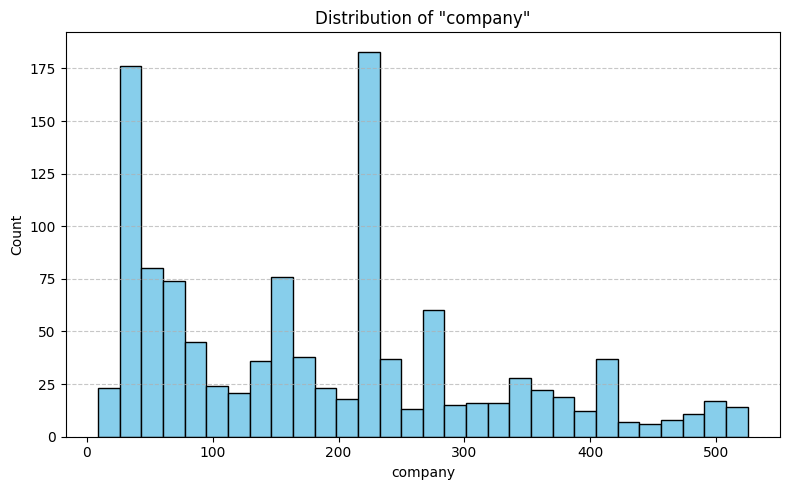

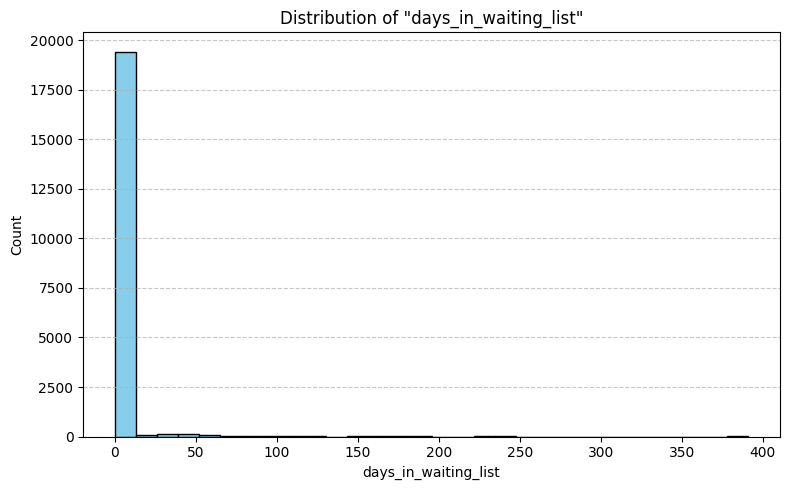

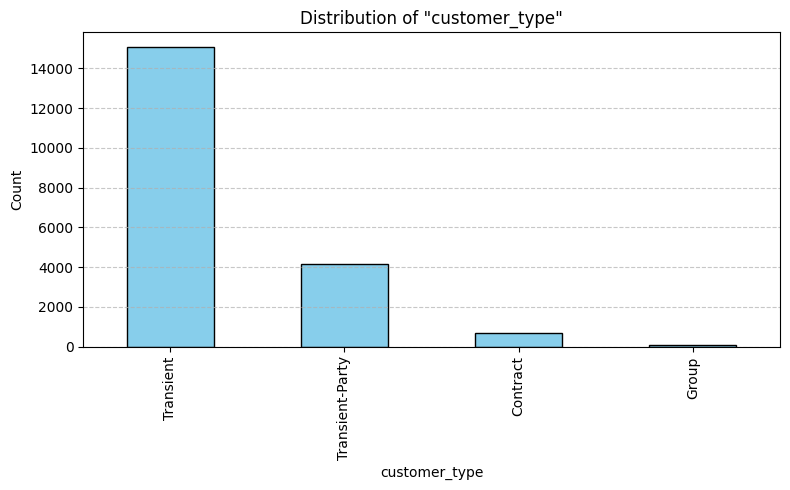

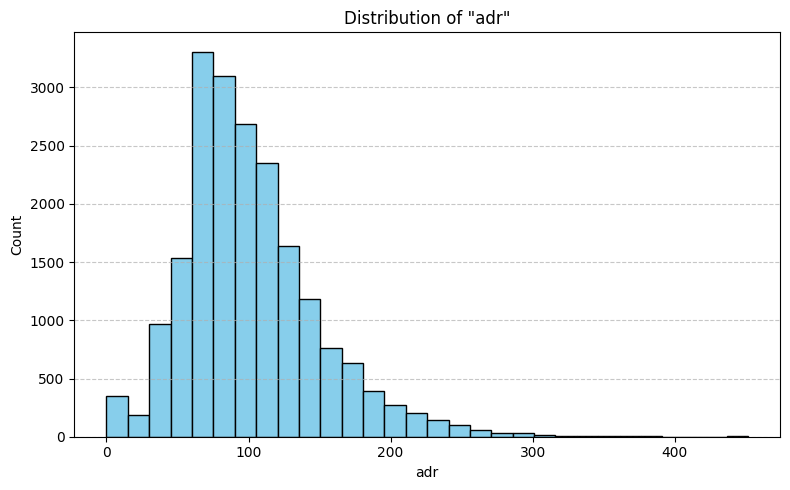

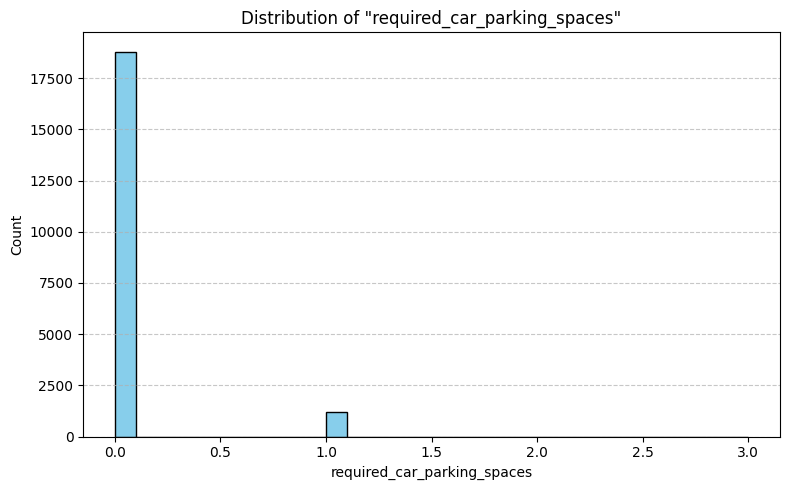

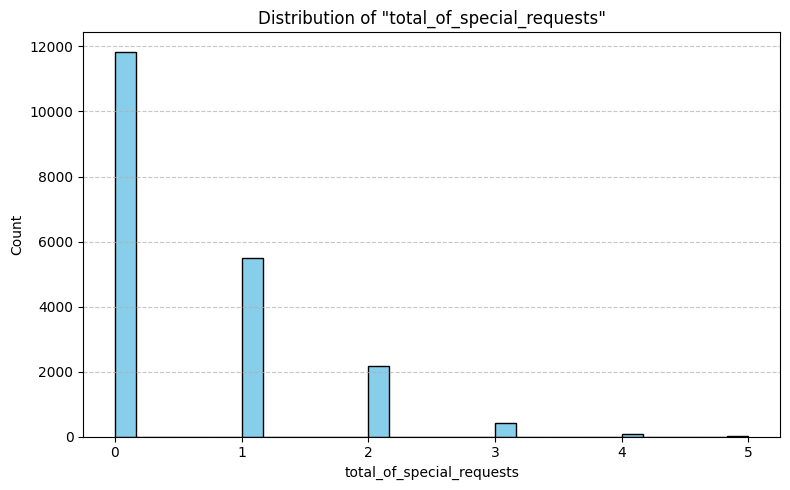

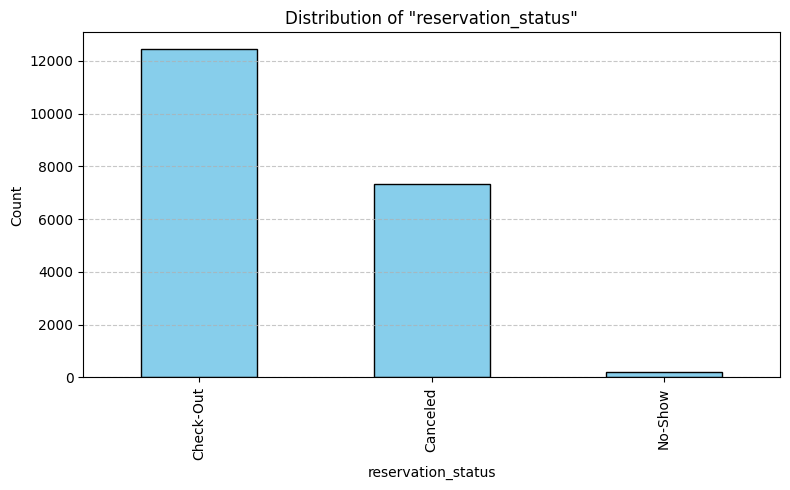

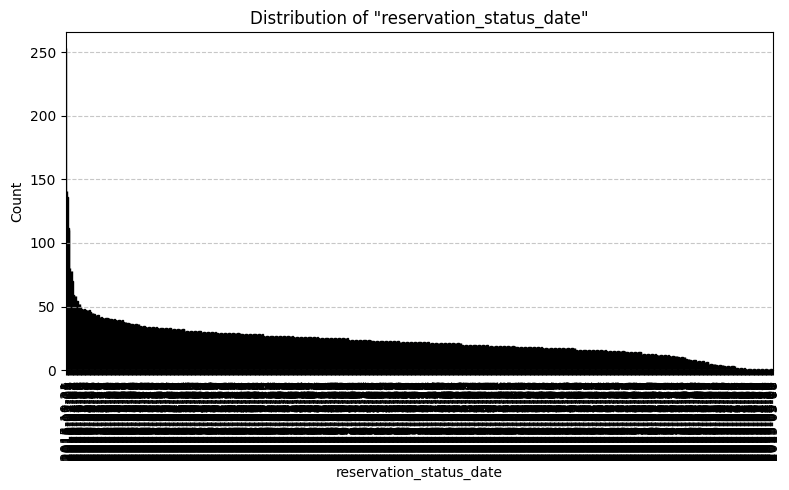

In [ ]:
# Create distribution plots
for col in sample_df.columns:
    plt.figure(figsize=(8, 5))
    if sample_df[col].dtype == 'object':
        sample_df[col].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    else:
        sample_df[col].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of "{col}"')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

#1 - Preparing the Data for Clustering

Encoding, cleaning, and standardizing the dataset to prepare it for clustering.

In [ ]:
df_encoded = sample_df.copy()
label_encoders = {}

# Encoding categorical (object) columns
for col in sample_df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(sample_df[col])
    label_encoders[col] = le  # For future use, if you want to reverse the transformation

label_col    = df_encoded['reservation_status']
print(label_col[:5])


0    1
1    0
2    1
3    1
4    1
Name: reservation_status, dtype: int64


Detect and Remove Problematic Features Before Dimensionality Reduction

Low variance features: ['babies', 'is_repeated_guest', 'required_car_parking_spaces']
babies                                0.011592
is_repeated_guest                     0.031913
required_car_parking_spaces           0.057223
deposit_type                          0.115754
children                              0.160127
hotel                                 0.224363
is_canceled                           0.234858
reservation_status                    0.248820
customer_type                         0.332968
adults                                0.395256
booking_changes                       0.419185
arrival_date_year                     0.501508
total_of_special_requests             0.637655
previous_cancellations                0.677131
distribution_channel                  0.838174
stays_in_weekend_nights               0.989597
meal                                  1.140611
market_segment                        1.615007
previous_bookings_not_canceled        2.467377
reserved_room_type   

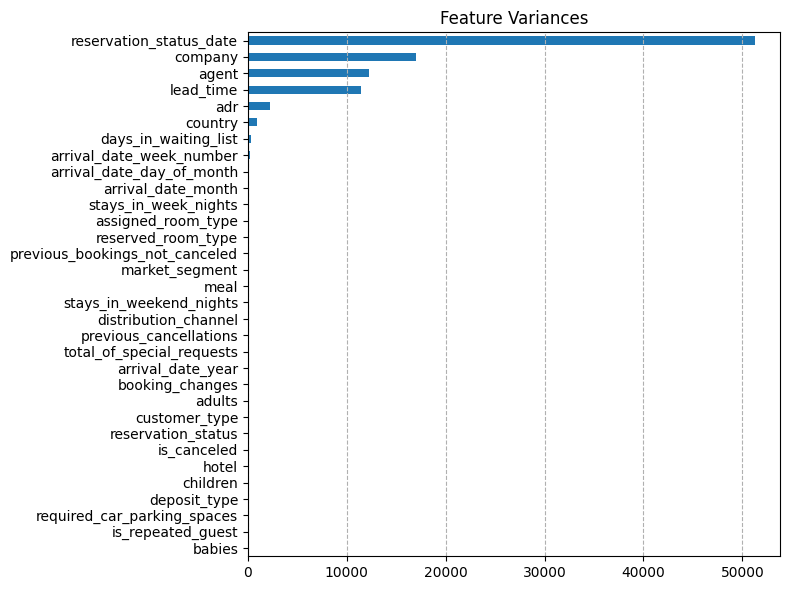

In [ ]:
# Find features with low variance
low_var = df_encoded.var() < 0.1
print("Low variance features:", df_encoded.columns[low_var].tolist())

variances = df_encoded.var().sort_values()
print(variances)
variances.plot(kind='barh', figsize=(8, 6))
plt.title("Feature Variances")
plt.grid(True, axis='x', linestyle='--')
plt.tight_layout()
plt.show()


In [ ]:
#Droping unwanted columns
columns_to_drop = [
    'reservation_status_date',
    'company',
    'agent',
    'is_canceled',
    'arrival_date_year',
    'arrival_date_month',
    'country',
    'previous_bookings_not_canceled',
    'days_in_waiting_list',
    'babies',
    'is_repeated_guest',
    'required_car_parking_spaces',
    'reservation_status'

]
df_encoded = df_encoded.drop(columns=[col for col in columns_to_drop if col in df_encoded.columns])
sample_df = sample_df.drop(columns=[col for col in columns_to_drop if col in sample_df.columns])
print(f"Currently working on a sample of {df_encoded.shape[0]} records and {df_encoded.shape[1]} columns.")
df_encoded.head()
print(df_encoded.shape)



Currently working on a sample of 20000 records and 19 columns.
(20000, 19)


In [ ]:
# Standardization
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_encoded)

from IPython.display import display
display(df_encoded.head(10))  # Displaying the first 10 rows in a clear table
print(type(scaled_data))

,hotel,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,meal,market_segment,distribution_channel,previous_cancellations,reserved_room_type,assigned_room_type,booking_changes,deposit_type,customer_type,adr,total_of_special_requests
0,1,203,49,2,2,5,2,0.0,0,3,1,0,5,5,4,0,2,66.80,0
1,0,82,29,16,0,3,2,0.0,0,6,3,0,0,0,0,0,2,76.50,0
2,0,25,53,27,0,3,3,0.0,0,5,3,0,0,9,2,0,3,60.00,1
3,0,1,11,9,0,1,1,0.0,0,6,3,0,0,0,0,0,3,95.00,0
4,0,70,16,16,2,2,2,0.0,3,6,3,0,0,0,0,0,2,108.00,0
5,0,170,17,27,0,3,2,0.0,0,6,3,0,3,3,0,0,2,130.50,0
6,0,21,10,4,0,1,1,0.0,0,6,3,0,0,0,0,0,3,85.00,0
7,0,102,42,16,0,2,2,0.0,2,5,3,0,0,3,0,0,3,109.00,0
8,1,55,47,19,2,5,2,0.0,2,6,3,0,3,3,1,0,2,67.44,0
9,1,222,38,14,1,1,2,0.0,2,4,3,0,0,0,0,0,2,80.00,0


<class 'numpy.ndarray'>


#2 - What is the best way to do dimension reduction

##PCA

Silhouette Score for 2 clusters: 0.4370953719631004
Silhouette Score for 3 clusters: 0.4793068009054063
Silhouette Score for 4 clusters: 0.37545093904412036
Silhouette Score for 5 clusters: 0.39272875141487307
Silhouette Score for 6 clusters: 0.39936063059315724
Silhouette Score for 7 clusters: 0.4072547823908768
Silhouette Score for 8 clusters: 0.375347194977299
Silhouette Score for 9 clusters: 0.3698170816390939
Silhouette Score for 10 clusters: 0.37217587620443365
Silhouette Score for 11 clusters: 0.36457804824058376
Silhouette Score for 12 clusters: 0.36719816424777657
Silhouette Score for 13 clusters: 0.34760178935889574
Silhouette Score for 14 clusters: 0.34905417466708516
Silhouette Score for 15 clusters: 0.34787751018732194
Silhouette Score for 16 clusters: 0.3474046373041227


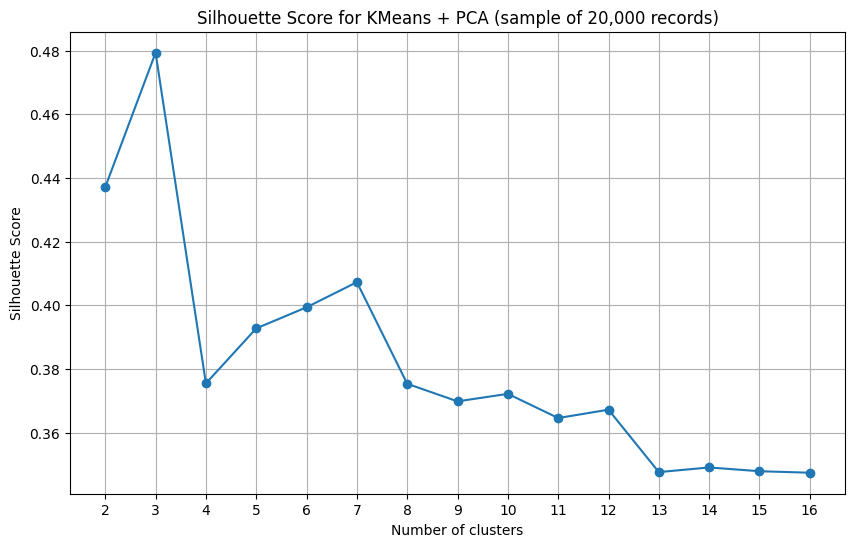

In [ ]:
# Data processing, clustering, and Silhouette Score visualization for PCA
# Dimensionality reduction with PCA to 2 dimensions
pca = PCA(n_components=2)
pca_reduced_data = pca.fit_transform(scaled_data)

# Running KMeans with a varying number of clusters using Silhouette Score
cluster_counts = list(range(2, 17))
silhouette_values = []

for n_clusters in cluster_counts:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_reduced_data)
    score = silhouette_score(pca_reduced_data, cluster_labels)
    silhouette_values.append(score)
    print(f"Silhouette Score for {n_clusters} clusters: {score}")

# Displaying the Silhouette Score plot
plt.figure(figsize=(10, 6))
plt.plot(cluster_counts, silhouette_values, marker='o')
plt.title('Silhouette Score for KMeans + PCA (sample of 20,000 records)')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_counts)
plt.grid(True)

# Save as vector graphics
plt.savefig("PCA_silhouette_score_plot.pdf")  # Save as PDF
plt.show()


##ICA

Silhouette Score for 2 clusters: 0.4703397351374384
Silhouette Score for 3 clusters: 0.4790713862349602
Silhouette Score for 4 clusters: 0.45872268678831624
Silhouette Score for 5 clusters: 0.3721733877178247
Silhouette Score for 6 clusters: 0.3855999839522664
Silhouette Score for 7 clusters: 0.3991917276856177
Silhouette Score for 8 clusters: 0.39475626937157965
Silhouette Score for 9 clusters: 0.37833913795476176
Silhouette Score for 10 clusters: 0.34918963703911016
Silhouette Score for 11 clusters: 0.3515127206312485
Silhouette Score for 12 clusters: 0.3524534347029274
Silhouette Score for 13 clusters: 0.3483540125369163
Silhouette Score for 14 clusters: 0.33389103420124505
Silhouette Score for 15 clusters: 0.34331960599607025
Silhouette Score for 16 clusters: 0.33939838124134897


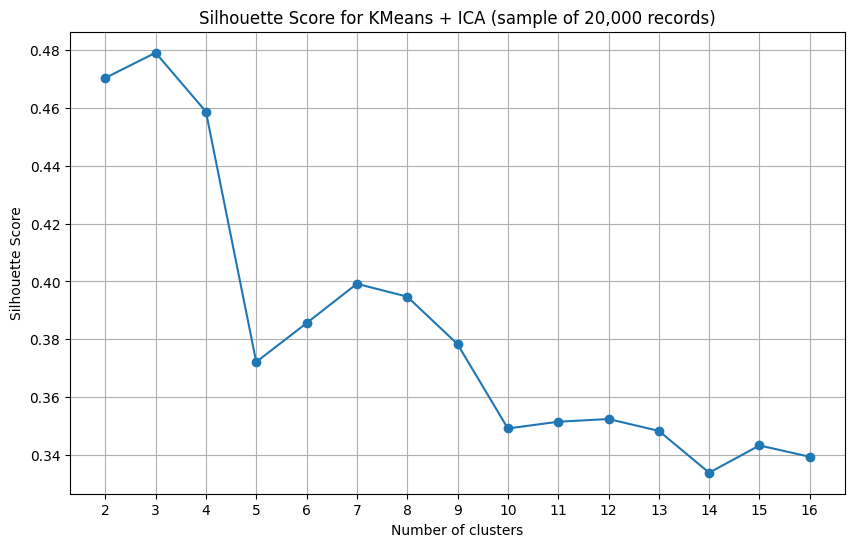

In [ ]:
# Filter out columns with zero variance
variances = scaled_data.var(axis=0)
non_zero_var_indices = np.where(variances > 1e-10)[0]
ica_scaled_data = scaled_data[:, non_zero_var_indices]

# Ensure no NaN or infinite values
ica_scaled_data = np.nan_to_num(ica_scaled_data, nan=0.0, posinf=0.0, neginf=0.0)

# Dimensionality reduction with ICA to 2 components
ica = FastICA(n_components=2, random_state=42)
ica_reduced_data = ica.fit_transform(ica_scaled_data)

# Run KMeans with varying numbers of clusters using Silhouette Score
cluster_counts = list(range(2, 17))
silhouette_values = []

for n_clusters in cluster_counts:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(ica_reduced_data)
    score = silhouette_score(ica_reduced_data, cluster_labels)
    silhouette_values.append(score)
    print(f"Silhouette Score for {n_clusters} clusters: {score}")

# Plotting the Silhouette Score graph
plt.figure(figsize=(10, 6))
plt.plot(cluster_counts, silhouette_values, marker='o')
plt.title('Silhouette Score for KMeans + ICA (sample of 20,000 records)')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_counts)
plt.grid(True)

# Save the figure as a vector graphic
plt.savefig("ICA_silhouette_score_plot.pdf")

plt.show()


##TSNE

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette Score for 2 clusters: 0.3405075669288635
Silhouette Score for 3 clusters: 0.37521910667419434
Silhouette Score for 4 clusters: 0.3659478425979614
Silhouette Score for 5 clusters: 0.36166831851005554
Silhouette Score for 6 clusters: 0.38027116656303406
Silhouette Score for 7 clusters: 0.3803957402706146
Silhouette Score for 8 clusters: 0.35805144906044006
Silhouette Score for 9 clusters: 0.35841861367225647
Silhouette Score for 10 clusters: 0.36282679438591003
Silhouette Score for 11 clusters: 0.35936588048934937
Silhouette Score for 12 clusters: 0.37949442863464355
Silhouette Score for 13 clusters: 0.39200279116630554
Silhouette Score for 14 clusters: 0.3761877119541168
Silhouette Score for 15 clusters: 0.37257087230682373
Silhouette Score for 16 clusters: 0.3674156367778778


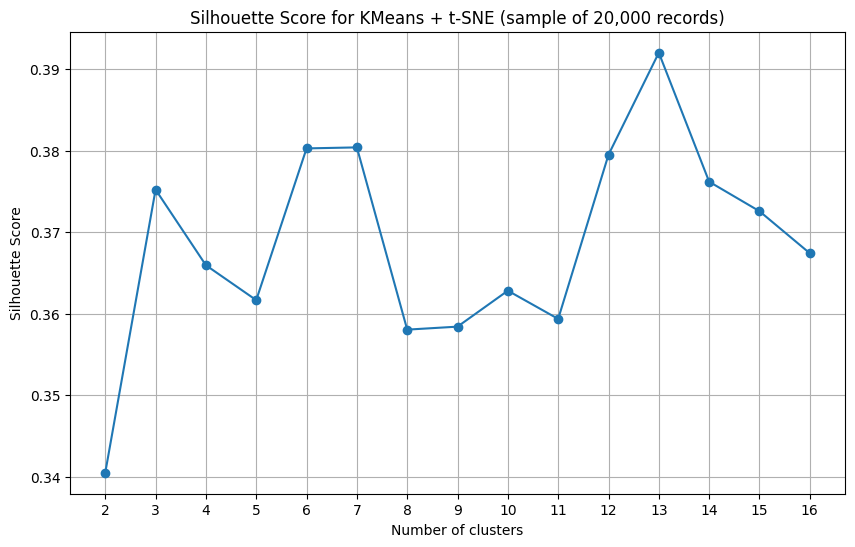

In [ ]:
# Dimensionality reduction with t-SNE to 2 components
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
tsne_reduced_data = tsne.fit_transform(scaled_data)

# Run KMeans with varying numbers of clusters using Silhouette Score
cluster_counts = list(range(2, 17))
silhouette_values = []

for n_clusters in cluster_counts:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(tsne_reduced_data)
    score = silhouette_score(tsne_reduced_data, cluster_labels)
    silhouette_values.append(score)
    print(f"Silhouette Score for {n_clusters} clusters: {score}")

# Plotting the Silhouette Score graph
plt.figure(figsize=(10, 6))
plt.plot(cluster_counts, silhouette_values, marker='o')
plt.title('Silhouette Score for KMeans + t-SNE (sample of 20,000 records)')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_counts)
plt.grid(True)

# Save the figure as a vector graphic
plt.savefig("TSNE_silhouette_score_plot.pdf")

plt.show()


##ISOMAP

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.11/dist-packag

Silhouette Score for 16 clusters: 0.42167528593409115
Silhouette Score for 16 clusters: 0.49184137784680587
Silhouette Score for 16 clusters: 0.49165922573682874
Silhouette Score for 16 clusters: 0.4416374713881355
Silhouette Score for 16 clusters: 0.48437441714115065
Silhouette Score for 16 clusters: 0.490890082305069
Silhouette Score for 16 clusters: 0.5028963035646131
Silhouette Score for 16 clusters: 0.5415041423748851
Silhouette Score for 16 clusters: 0.4951532206650664
Silhouette Score for 16 clusters: 0.5001065673842965
Silhouette Score for 16 clusters: 0.46920073524921263
Silhouette Score for 16 clusters: 0.4918075657201669
Silhouette Score for 16 clusters: 0.48514304555920396
Silhouette Score for 16 clusters: 0.4723992392665522
Silhouette Score for 16 clusters: 0.47867212605904186
Optimal number of clusters based on Silhouette Score: 9


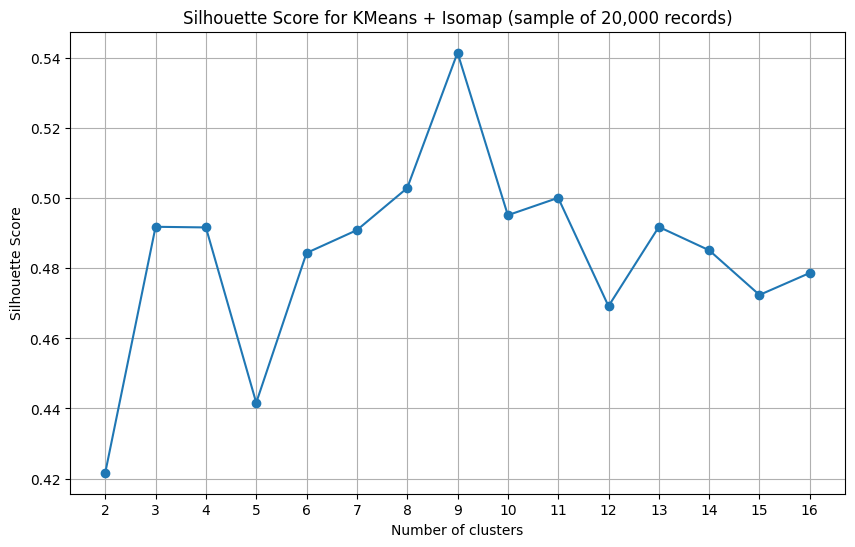

In [ ]:
# Dimensionality reduction with Isomap to 2 components
isomap = Isomap(n_components=2)
isomap_reduced_data = isomap.fit_transform(scaled_data)

# Run KMeans with varying numbers of clusters using Silhouette Score
cluster_counts = list(range(2, 17))
silhouette_values = []

for n_clusters_test in cluster_counts:
    kmeans = KMeans(n_clusters=n_clusters_test, random_state=42)
    cluster_labels = kmeans.fit_predict(isomap_reduced_data)
    score = silhouette_score(isomap_reduced_data, cluster_labels)
    silhouette_values.append(score)
    print(f"Silhouette Score for {n_clusters} clusters: {score}")

# Find and store the optimal number of clusters
best_n_clusters = cluster_counts[np.argmax(silhouette_values)]
print(f"Optimal number of clusters based on Silhouette Score: {best_n_clusters}")

# Plotting the Silhouette Score graph
plt.figure(figsize=(10, 6))
plt.plot(cluster_counts, silhouette_values, marker='o')
plt.title('Silhouette Score for KMeans + Isomap (sample of 20,000 records)')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_counts)
plt.grid(True)

# Save the figure as a vector graphic
plt.savefig("Isomap_silhouette_score_plot.pdf")

plt.show()

##UMAP

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Silhouette Score for 2 clusters: 0.3664673864841461
Silhouette Score for 3 clusters: 0.40926674008369446
Silhouette Score for 4 clusters: 0.4384966790676117
Silhouette Score for 5 clusters: 0.43667665123939514
Silhouette Score for 6 clusters: 0.4366067945957184
Silhouette Score for 7 clusters: 0.4449562430381775
Silhouette Score for 8 clusters: 0.4429051876068115
Silhouette Score for 9 clusters: 0.4495529234409332
Silhouette Score for 10 clusters: 0.47892120480537415
Silhouette Score for 11 clusters: 0.4789066016674042
Silhouette Score for 12 clusters: 0.4938570261001587
Silhouette Score for 13 clusters: 0.5154379606246948
Silhouette Score for 14 clusters: 0.520370602607727
Silhouette Score for 15 clusters: 0.5197498202323914
Silhouette Score for 16 clusters: 0.5318812131881714


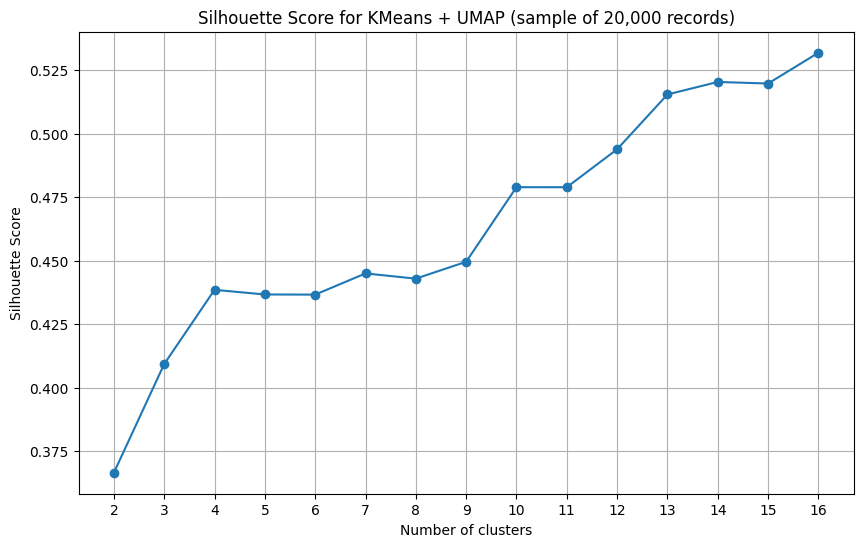

In [ ]:
# Dimensionality reduction with UMAP to 2 components
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_reduced_data = umap_reducer.fit_transform(scaled_data)

# Run KMeans with varying numbers of clusters using Silhouette Score
cluster_counts = list(range(2, 17))
silhouette_values = []

for n_clusters in cluster_counts:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(umap_reduced_data)
    score = silhouette_score(umap_reduced_data, cluster_labels)
    silhouette_values.append(score)
    print(f"Silhouette Score for {n_clusters} clusters: {score}")

# Plotting the Silhouette Score graph
plt.figure(figsize=(10, 6))
plt.plot(cluster_counts, silhouette_values, marker='o')
plt.title('Silhouette Score for KMeans + UMAP (sample of 20,000 records)')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_counts)
plt.grid(True)

# Save the figure as a vector graphic
plt.savefig("UMAP_silhouette_score_plot.pdf")

plt.show()


# 3 - Clustering with Standard Methods


In [ ]:
!pip install igraph leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.5 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


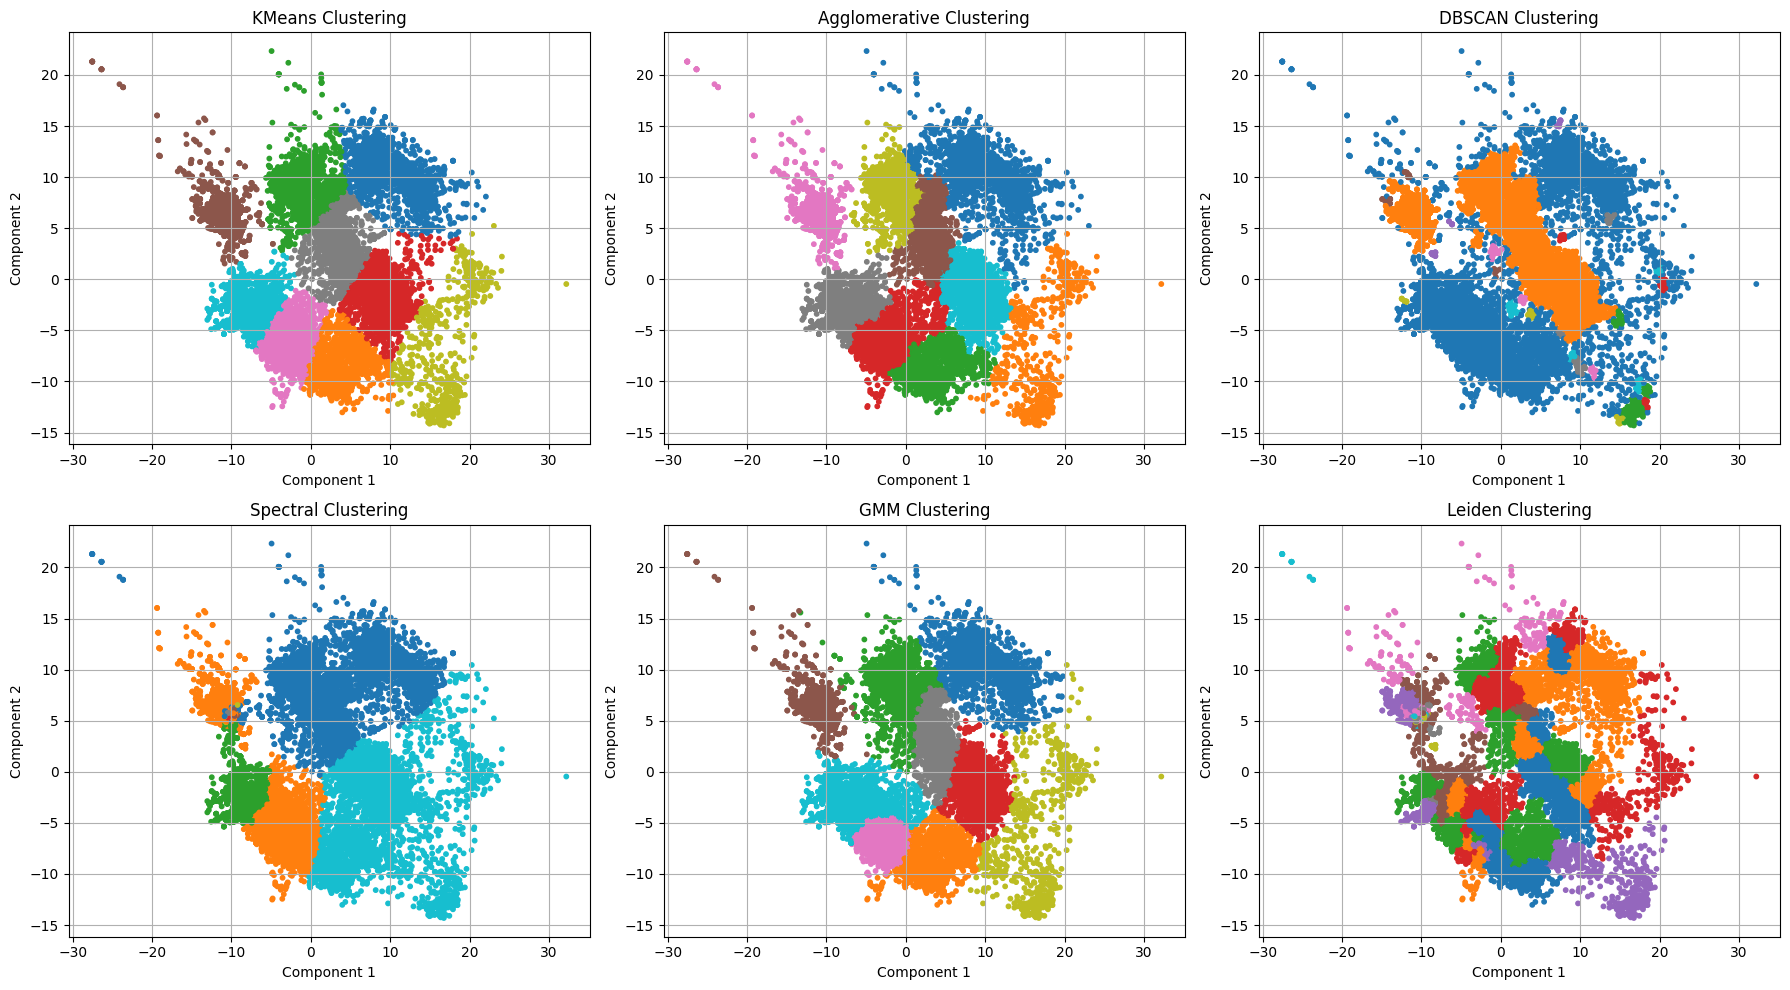

  Clustering Method  Silhouette Score
0            KMeans          0.541504
1     Agglomerative          0.514882
4               GMM          0.513687
5            Leiden          0.184289
3          Spectral          0.132806
2            DBSCAN         -0.044111


<ipython-input-20-6130e2ffcc0d>:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=silhouette_df, x='Silhouette Score', y='Clustering Method', palette='viridis')


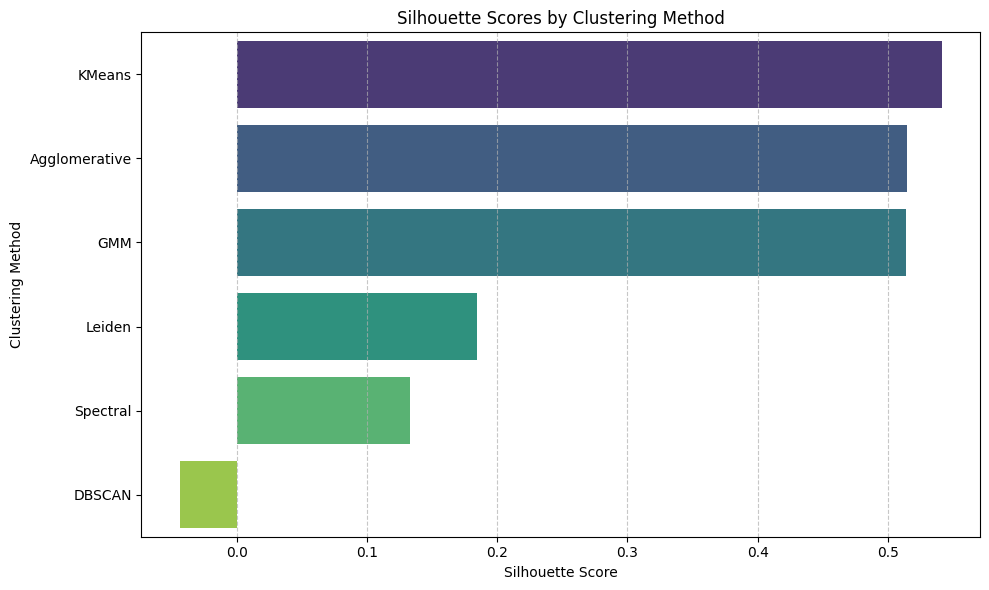

In [ ]:

reduced_data = isomap_reduced_data
n_clusters = best_n_clusters

# KMeans
kmeans = KMeans(n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(reduced_data)

# Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters)
agg_labels = agg.fit_predict(reduced_data)

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(reduced_data)

# Spectral Clustering
spectral = SpectralClustering(n_clusters, affinity='nearest_neighbors', random_state=42)
spectral_labels = spectral.fit_predict(reduced_data)

# Gaussian Mixture Model
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(reduced_data)

# ========== Leiden Clustering ==========

import igraph as ig
import leidenalg
from sklearn.neighbors import kneighbors_graph

# Build a KNN graph
knn_graph = kneighbors_graph(reduced_data, n_neighbors=10, include_self=False)
sources, targets = knn_graph.nonzero()
edges = list(zip(sources.tolist(), targets.tolist()))

# Create igraph graph
g = ig.Graph(edges=edges, directed=False)
g.vs["name"] = list(range(reduced_data.shape[0]))

# Run Leiden
partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition)
leiden_labels = np.array(partition.membership)



cluster_results = {
    "KMeans": kmeans_labels,
    "Agglomerative": agg_labels,
    "DBSCAN": dbscan_labels,
    "Spectral": spectral_labels,
    "GMM": gmm_labels,
    "Leiden": leiden_labels
}

# Define color map
cmap = 'tab10'

# Create grid of scatter plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (method, labels) in enumerate(cluster_results.items()):
    ax = axes[i]
    ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap=cmap, s=10)
    ax.set_title(f"{method} Clustering")
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("clustering_results.pdf")
plt.show()

# Compute Silhouette Scores
silhouette_scores = {}
for method, labels in cluster_results.items():
    if method == "DBSCAN" and (len(set(labels)) <= 1 or -1 not in labels):
        silhouette_scores[method] = np.nan
    else:
        if method == "DBSCAN":
            mask = labels != -1
            score = silhouette_score(reduced_data[mask], np.array(labels)[mask])
        else:
            score = silhouette_score(reduced_data, labels)
        silhouette_scores[method] = score

# Convert to DataFrame
silhouette_df = pd.DataFrame({
    'Clustering Method': list(silhouette_scores.keys()),
    'Silhouette Score': list(silhouette_scores.values())
}).sort_values(by='Silhouette Score', ascending=False)
print(silhouette_df)
# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
sns.barplot(data=silhouette_df, x='Silhouette Score', y='Clustering Method', palette='viridis')
plt.title('Silhouette Scores by Clustering Method')
plt.xlabel('Silhouette Score')
plt.ylabel('Clustering Method')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("silhouette_plot.pdf")
plt.show()


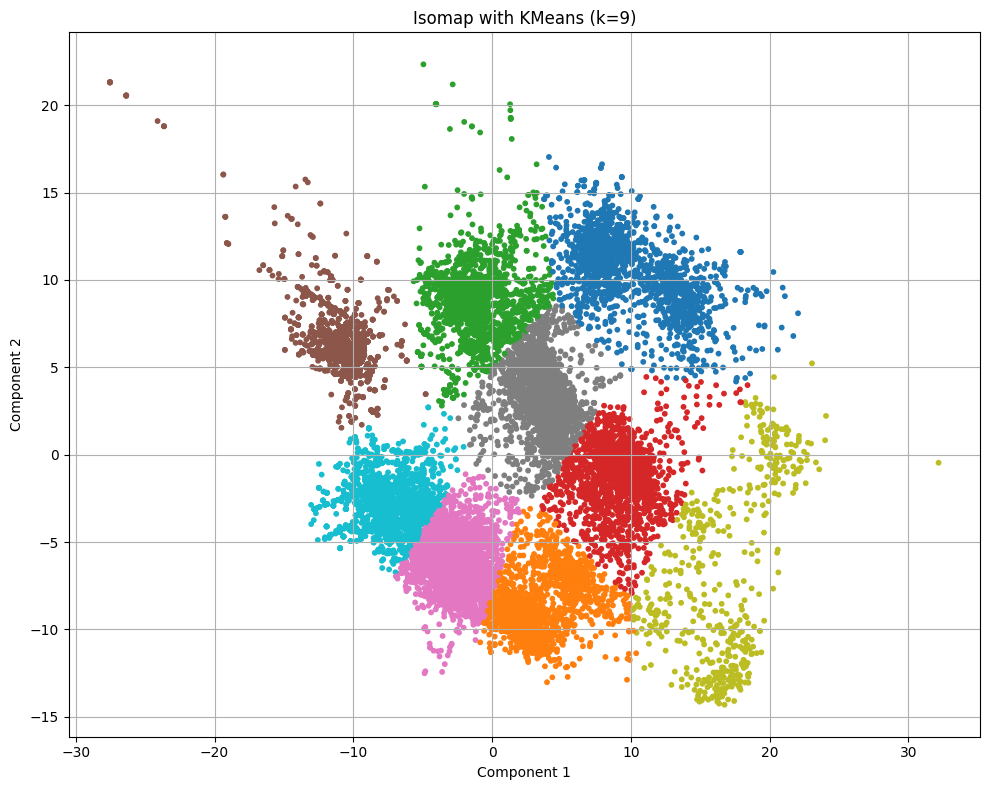

In [ ]:
# Fit KMeans again on both reduced spaces using best_n_clusters
kmeans_isomap = KMeans(n_clusters=best_n_clusters, random_state=42)
labels_isomap = kmeans_isomap.fit_predict(isomap_reduced_data)

# Plot Isomap clustering result
plt.figure(figsize=(10, 8))
plt.scatter(isomap_reduced_data[:, 0], isomap_reduced_data[:, 1], c=labels_isomap, cmap='tab10', s=10)
plt.title(f'Isomap with KMeans (k={best_n_clusters})')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)


plt.tight_layout()
plt.savefig("Isomap_kmeans_cluster.pdf")
plt.show()


# 4 - Finding the Most Influential Feature for Clustering

🧪 Mutual Information for Feature Importance
We use Mutual Information (MI) and Normalized Mutual Information (NMI) to evaluate how much information a categorical feature shares with the cluster labels.

Unlike linear methods (e.g., ANOVA), MI does not assume linear relationships and is well-suited for complex, non-linear data structures — such as those produced by dimensionality reduction methods like UMAP or t-SNE.

This makes MI a robust and flexible choice for identifying which categorical features are most informative in distinguishing between clusters.



                      Feature         Type  Mutual Information
17                        adr    Numerical            0.610603
2              market_segment  Categorical            0.596802
0                       hotel  Categorical            0.429447
4          reserved_room_type  Categorical            0.396792
5          assigned_room_type  Categorical            0.358117
3        distribution_channel  Categorical            0.353483
6                deposit_type  Categorical            0.332376
8                   lead_time    Numerical            0.256028
7               customer_type  Categorical            0.176544
1                        meal  Categorical            0.129091
14                   children    Numerical            0.128801
18  total_of_special_requests    Numerical            0.111673
12       stays_in_week_nights    Numerical            0.086895
13                     adults    Numerical            0.067243
15     previous_cancellations    Numerical            0

<ipython-input-34-56d49e86bcbe>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Mutual Information', y='Feature', palette=palette)


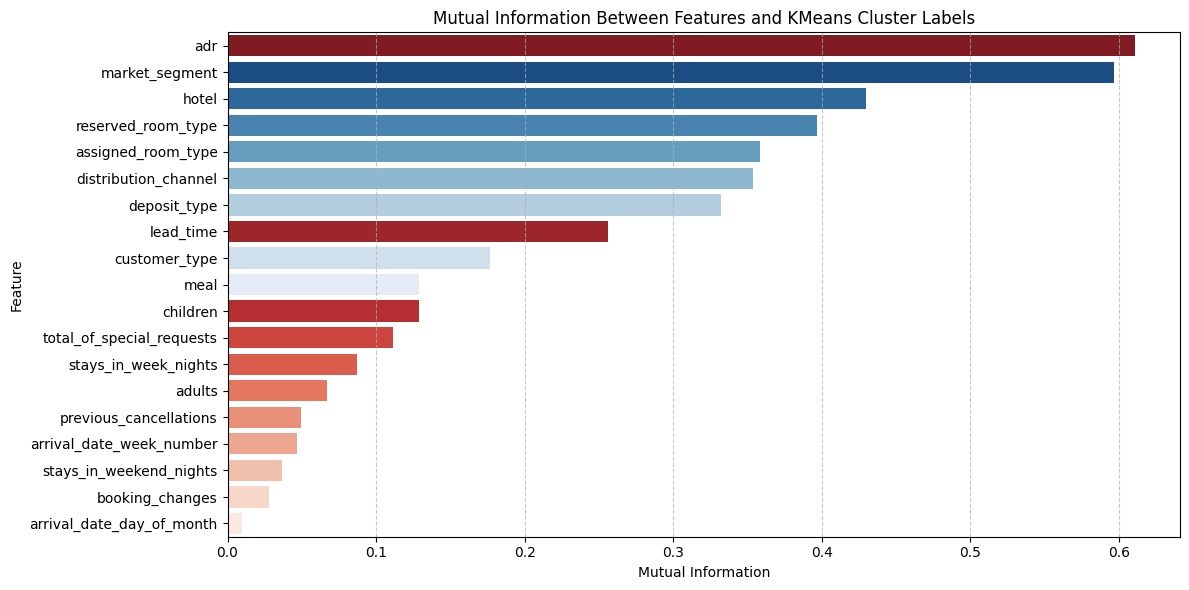

In [34]:
df = sample_df.copy()


df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna('Missing')


for col in df.select_dtypes(include='number').columns:
    df[col] = df[col].fillna(df[col].median())


categorical_cols = df.select_dtypes(include='object').columns.tolist()
numerical_cols   = [c for c in df.select_dtypes(include='number').columns
                    if c != 'cluster']


results = []


for col in categorical_cols:
    mi = mutual_info_score(df[col], kmeans_labels)
    results.append({'Feature': col, 'Type': 'Categorical', 'Mutual Information': mi})


mi_numeric = mutual_info_classif(df[numerical_cols], kmeans_labels, random_state=42)
for col, mi in zip(numerical_cols, mi_numeric):
    results.append({'Feature': col, 'Type': 'Numerical', 'Mutual Information': mi})


results_df = (pd.DataFrame(results)
              .sort_values(by='Mutual Information', ascending=False))


results_df = results_df[results_df['Feature'] != 'cluster']
print(results_df)

palette_cat = sns.color_palette("Blues",  n_colors=results_df.Type.eq('Categorical').sum())[::-1]
palette_num = sns.color_palette("Reds",   n_colors=results_df.Type.eq('Numerical').sum())[::-1]
palette = []
for _, row in results_df.iterrows():
    if row['Type']=='Categorical': palette.append(palette_cat.pop(0))
    else:                        palette.append(palette_num.pop(0))

plt.figure(figsize=(12,6))
sns.barplot(data=results_df, x='Mutual Information', y='Feature', palette=palette)
plt.title('Mutual Information Between Features and KMeans Cluster Labels')
plt.xlabel('Mutual Information'); plt.ylabel('Feature')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("mutual_information_plot.pdf")
plt.show()


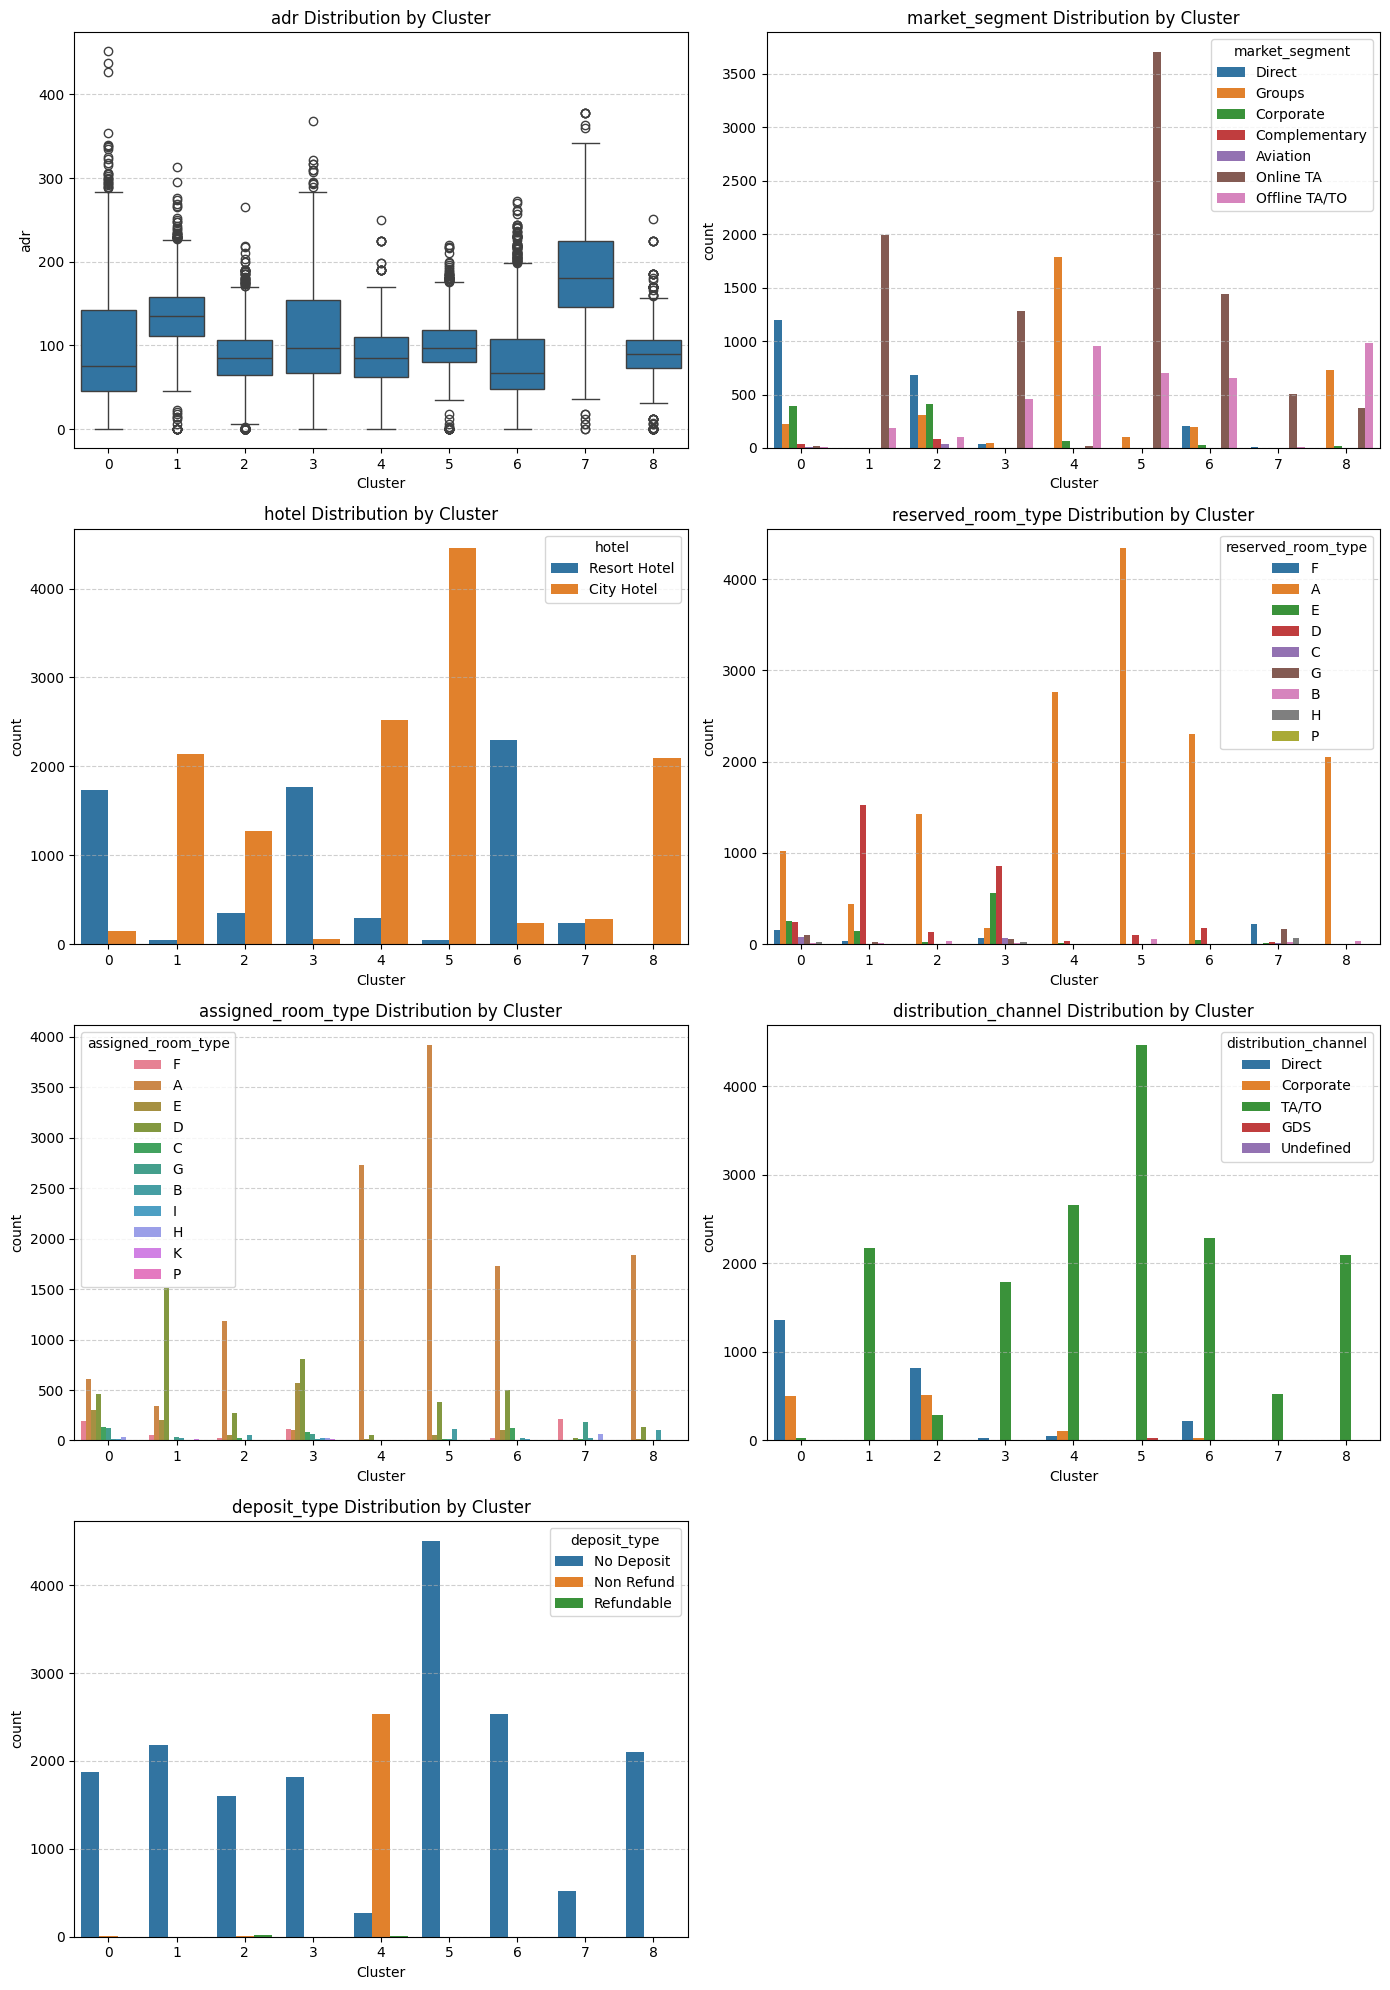

In [ ]:
top_features = ['adr', 'market_segment', 'hotel', 'reserved_room_type','assigned_room_type','distribution_channel','deposit_type']

n_cols = 2
n_rows = (len(top_features) + 1) // n_cols
sample_df['cluster'] = kmeans.labels_
plt.figure(figsize=(14, 5 * n_rows))

for i, feature in enumerate(top_features, 1):
    plt.subplot(n_rows, n_cols, i)

    if sample_df[feature].dtype == 'object' or sample_df[feature].nunique() < 15:
        # categorical
        sns.countplot(data=sample_df, x='cluster', hue=feature)
        plt.legend(title=feature)
    else:
        # numeric
        sns.boxplot(data=sample_df, x='cluster', y=feature)

    plt.title(f"{feature} Distribution by Cluster")
    plt.xlabel("Cluster")
    plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig("cluster_distributions.pdf")
plt.show()


# 5 - Define Each Cluster

In [ ]:
sample_df['reservation_status'] = label_col

#  Contingency table
ct = pd.crosstab(sample_df['cluster'], sample_df['reservation_status'])
print("Contingency table:\n", ct, "\n")

#  Chi-square test of independence
chi2, p, dof, expected = chi2_contingency(ct)
print(f"Chi2 = {chi2:.2f}, p-value = {p:.2e}, dof = {dof}\n")

#  Cramér’s V
n = sample_df.shape[0]
min_dim = min(ct.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))
print(f"Cramér’s V = {cramers_v:.3f}\n")

#  Agreement metrics between the true labels and the cluster labels
ari = adjusted_rand_score(sample_df['reservation_status'], sample_df['cluster'])
nmi = normalized_mutual_info_score(sample_df['reservation_status'], sample_df['cluster'])
print(f"Adjusted Rand Index = {ari:.3f}")
print(f"Normalized Mutual Info = {nmi:.3f}\n")

#  Simple "classifier": map each cluster to its most frequent reservation status
mapping = (
    sample_df
    .groupby('cluster')['reservation_status']
    .agg(lambda x: x.value_counts().idxmax())
)
print("Cluster → Predicted status mapping:\n", mapping, "\n")

# Compute prediction accuracy
preds = sample_df['cluster'].map(mapping)
accuracy = (preds == sample_df['reservation_status']).mean()
print(f"Simple mapping accuracy = {accuracy:.3%}")


Contingency table:
 reservation_status     0     1   2
cluster                           
0                    284  1585  19
1                    789  1369  27
2                    263  1340  21
3                    526  1280  16
4                   2664   149   5
5                   1438  3007  58
6                    625  1894  14
7                    236   287   3
8                    523  1551  27 

Chi2 = 5139.19, p-value = 0.00e+00, dof = 16

Cramér’s V = 0.358

Adjusted Rand Index = 0.056
Normalized Mutual Info = 0.098

Cluster → Predicted status mapping:
 cluster
0    1
1    1
2    1
3    1
4    0
5    1
6    1
7    1
8    1
Name: reservation_status, dtype: int64 

Simple mapping accuracy = 74.885%


##Statistics for Each Cluster


In [ ]:
# Number of Observations in Each Cluster

print(sample_df['cluster'].value_counts().sort_index())


cluster
0    1888
1    2185
2    1624
3    1822
4    2818
5    4503
6    2533
7     526
8    2101
Name: count, dtype: int64


In [ ]:
df_encoded['cluster'] = kmeans_labels
numeric_summary = (
    df_encoded
      .groupby('cluster')[top_features]
      .agg(['mean','median','std'])
)
# flatten column names
numeric_summary.columns = ['_'.join(col).strip() for col in numeric_summary.columns.values]
numeric_summary


,adr_mean,adr_median,adr_std,market_segment_mean,market_segment_median,market_segment_std,hotel_mean,hotel_median,hotel_std,reserved_room_type_mean,...,reserved_room_type_std,assigned_room_type_mean,assigned_room_type_median,assigned_room_type_std,distribution_channel_mean,distribution_channel_median,distribution_channel_std,deposit_type_mean,deposit_type_median,deposit_type_std
cluster,,,,,,,,,,,,,,,,,,,,,
0,98.225477,75.00,69.587859,2.891419,3.0,0.724593,0.921610,1.0,0.268855,1.853814,...,2.184841,2.630297,3.0,2.153607,0.763242,1.0,0.510187,0.006886,0.0,0.082715
1,135.530975,135.00,37.482007,5.909840,6.0,0.297454,0.020595,0.0,0.142056,2.508924,...,1.346899,2.729977,3.0,1.402948,2.995423,3.0,0.073983,0.000000,0.0,0.000000
2,85.810462,84.70,37.729717,2.903941,3.0,1.041651,0.216133,0.0,0.411733,0.357143,...,1.009767,0.812808,0.0,1.451855,1.042488,1.0,1.017429,0.020320,0.0,0.195969
3,114.410856,97.31,61.771939,5.638858,6.0,0.630703,0.969265,1.0,0.172647,3.183864,...,1.346055,3.472558,3.0,1.438111,2.968167,3.0,0.250374,0.000549,0.0,0.023427
4,88.892814,85.00,29.911598,4.304826,4.0,0.598529,0.106458,0.0,0.308478,0.060681,...,0.446905,0.088006,0.0,0.518790,2.848474,3.0,0.627807,0.906317,1.0,0.303376
5,100.750988,97.00,27.388705,5.799689,6.0,0.453360,0.011326,0.0,0.105830,0.087275,...,0.487220,0.364868,0.0,1.047253,2.991561,3.0,0.107141,0.000000,0.0,0.000000
6,82.735172,67.50,48.484269,5.292538,6.0,1.002018,0.907619,1.0,0.289620,0.290959,...,0.933526,1.008291,0.0,1.615342,2.797079,3.0,0.630861,0.000790,0.0,0.028094
7,185.291806,180.00,64.363143,5.946768,6.0,0.328081,0.461977,0.0,0.499027,5.199620,...,1.410194,5.264259,5.0,1.365052,2.977186,3.0,0.212586,0.001901,0.0,0.043602
8,90.476592,90.00,27.276271,4.809614,5.0,0.743814,0.000952,0.0,0.030846,0.029034,...,0.223850,0.283674,0.0,0.857718,2.996668,3.0,0.089912,0.000000,0.0,0.000000


In [ ]:
cat_cols = sample_df.select_dtypes(include='object').columns
cat_summary = {}
for col in cat_cols:
    top = (
        sample_df
          .groupby('cluster')[col]
          .agg(lambda x: x.value_counts(normalize=True).idxmax())
    )
    cat_summary[col] = top

cat_summary = pd.DataFrame(cat_summary)
cat_summary


,hotel,meal,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type
cluster,,,,,,,,
0,Resort Hotel,BB,Direct,Direct,A,A,No Deposit,Transient
1,City Hotel,BB,Online TA,TA/TO,D,D,No Deposit,Transient
2,City Hotel,BB,Direct,Direct,A,A,No Deposit,Transient
3,Resort Hotel,BB,Online TA,TA/TO,D,D,No Deposit,Transient
4,City Hotel,BB,Groups,TA/TO,A,A,Non Refund,Transient
5,City Hotel,BB,Online TA,TA/TO,A,A,No Deposit,Transient
6,Resort Hotel,BB,Online TA,TA/TO,A,A,No Deposit,Transient
7,City Hotel,BB,Online TA,TA/TO,F,F,No Deposit,Transient
8,City Hotel,BB,Offline TA/TO,TA/TO,A,A,No Deposit,Transient-Party


In [ ]:
numeric_cols = sample_df.select_dtypes(include='number').drop(columns=['cluster']).columns

numeric_summary = (
    sample_df
      .groupby('cluster')[numeric_cols]
      .agg(['mean','median','std'])
)
# flatten column names
numeric_summary.columns = ['_'.join(col).strip() for col in numeric_summary.columns.values]
numeric_summary


,lead_time_mean,lead_time_median,lead_time_std,arrival_date_week_number_mean,arrival_date_week_number_median,arrival_date_week_number_std,arrival_date_day_of_month_mean,arrival_date_day_of_month_median,arrival_date_day_of_month_std,stays_in_weekend_nights_mean,...,booking_changes_std,adr_mean,adr_median,adr_std,total_of_special_requests_mean,total_of_special_requests_median,total_of_special_requests_std,reservation_status_mean,reservation_status_median,reservation_status_std
cluster,,,,,,,,,,,,,,,,,,,,,
0,50.586335,14.0,76.118440,27.166314,28.0,15.016398,15.957627,16.0,8.744159,0.835275,...,0.728584,98.225477,75.00,69.587859,0.453919,0.0,0.803408,0.859640,1.0,0.375314
1,87.128146,69.0,73.462856,27.016934,27.0,12.460861,16.076430,16.0,8.899166,1.004577,...,0.915946,135.530975,135.00,37.482007,0.936842,1.0,0.904629,0.651259,1.0,0.501946
2,72.911330,23.0,99.633120,27.095443,26.0,14.156336,15.798030,15.0,8.593717,0.680419,...,0.666410,85.810462,84.70,37.729717,0.355296,0.0,0.664195,0.850985,1.0,0.390852
3,95.957739,71.0,84.779145,28.055434,30.0,12.979928,16.105379,16.0,8.898592,1.548299,...,0.847938,114.410856,97.31,61.771939,0.900659,1.0,0.908505,0.720088,1.0,0.468236
4,215.305536,197.0,130.731439,27.738822,27.0,13.231155,15.646203,16.0,8.557232,0.624202,...,0.115439,88.892814,85.00,29.911598,0.032292,0.0,0.178803,0.056423,0.0,0.238345
5,76.849878,52.0,75.580611,26.187209,26.0,13.960638,15.997113,16.0,8.815788,0.913835,...,0.534688,100.750988,97.00,27.388705,0.758605,1.0,0.823441,0.693538,1.0,0.488218
6,88.321753,51.0,93.394733,26.583893,26.0,14.348839,15.509672,16.0,8.901848,1.156731,...,0.679122,82.735172,67.50,48.484269,0.716936,1.0,0.786448,0.758784,1.0,0.440638
7,99.619772,71.0,88.576918,27.608365,28.0,12.046048,16.480989,17.0,9.175673,1.298479,...,0.546197,185.291806,180.00,64.363143,0.673004,0.0,0.881294,0.557034,1.0,0.508572
8,135.883389,102.0,115.590950,28.286054,29.0,12.855036,15.603046,16.0,8.708697,0.708234,...,0.555621,90.476592,90.00,27.276271,0.291290,0.0,0.543240,0.763922,1.0,0.454032


In [ ]:
profile = pd.concat([numeric_summary, cat_summary], axis=1)
profile


,lead_time_mean,lead_time_median,lead_time_std,arrival_date_week_number_mean,arrival_date_week_number_median,arrival_date_week_number_std,arrival_date_day_of_month_mean,arrival_date_day_of_month_median,arrival_date_day_of_month_std,stays_in_weekend_nights_mean,...,reservation_status_median,reservation_status_std,hotel,meal,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type
cluster,,,,,,,,,,,,,,,,,,,,,
0,50.586335,14.0,76.118440,27.166314,28.0,15.016398,15.957627,16.0,8.744159,0.835275,...,1.0,0.375314,Resort Hotel,BB,Direct,Direct,A,A,No Deposit,Transient
1,87.128146,69.0,73.462856,27.016934,27.0,12.460861,16.076430,16.0,8.899166,1.004577,...,1.0,0.501946,City Hotel,BB,Online TA,TA/TO,D,D,No Deposit,Transient
2,72.911330,23.0,99.633120,27.095443,26.0,14.156336,15.798030,15.0,8.593717,0.680419,...,1.0,0.390852,City Hotel,BB,Direct,Direct,A,A,No Deposit,Transient
3,95.957739,71.0,84.779145,28.055434,30.0,12.979928,16.105379,16.0,8.898592,1.548299,...,1.0,0.468236,Resort Hotel,BB,Online TA,TA/TO,D,D,No Deposit,Transient
4,215.305536,197.0,130.731439,27.738822,27.0,13.231155,15.646203,16.0,8.557232,0.624202,...,0.0,0.238345,City Hotel,BB,Groups,TA/TO,A,A,Non Refund,Transient
5,76.849878,52.0,75.580611,26.187209,26.0,13.960638,15.997113,16.0,8.815788,0.913835,...,1.0,0.488218,City Hotel,BB,Online TA,TA/TO,A,A,No Deposit,Transient
6,88.321753,51.0,93.394733,26.583893,26.0,14.348839,15.509672,16.0,8.901848,1.156731,...,1.0,0.440638,Resort Hotel,BB,Online TA,TA/TO,A,A,No Deposit,Transient
7,99.619772,71.0,88.576918,27.608365,28.0,12.046048,16.480989,17.0,9.175673,1.298479,...,1.0,0.508572,City Hotel,BB,Online TA,TA/TO,F,F,No Deposit,Transient
8,135.883389,102.0,115.590950,28.286054,29.0,12.855036,15.603046,16.0,8.708697,0.708234,...,1.0,0.454032,City Hotel,BB,Offline TA/TO,TA/TO,A,A,No Deposit,Transient-Party


##Statistical Tests for Each Variable

Statistical Tests for Numerical Variables


In [ ]:
numeric_cols = sample_df.select_dtypes(include='number').drop(columns=['cluster']).columns

#  ANOVA
anova_results = []
for col in numeric_cols:
    groups = [ sample_df.loc[sample_df['cluster']==k, col].dropna()
               for k in sorted(sample_df['cluster'].unique()) ]
    F, p = f_oneway(*groups)
    anova_results.append({'feature':col, 'F':F, 'p_value':p})
anova_df = pd.DataFrame(anova_results).set_index('feature')
print("ANOVA results:\n", anova_df.sort_values('p_value').head(), "\n")

# If p<0.05, Tukey HSD
sig_features = anova_df[anova_df['p_value']<0.05].index.tolist()
print("Significant numeric features:", sig_features, "\n")

for col in sig_features:
    tukey = pairwise_tukeyhsd(
        endog=sample_df[col],
        groups=sample_df['cluster'],
        alpha=0.05
    )
    print(tukey.summary(), "\n")


ANOVA results:
                                      F  p_value
feature                                        
lead_time                   675.730251      0.0
stays_in_week_nights        262.099202      0.0
children                   2532.257403      0.0
adr                         576.290901      0.0
total_of_special_requests   408.550026      0.0 

Significant numeric features: ['lead_time', 'arrival_date_week_number', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'previous_cancellations', 'booking_changes', 'adr', 'total_of_special_requests', 'reservation_status'] 

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
     0      1   36.5418    0.0   27.2915   45.7921   True
     0      2    22.325    0.0   12.3616   32.2884   True
     0      3   45.3714    0.0   35.7034   55.0394   True
     0      4  164.7192    0.0  155.9637  173.47

Statistical Tests for Categorical Variables

In [ ]:
cat_cols = sample_df.select_dtypes(include='object').columns

for col in cat_cols:
    ct = pd.crosstab(sample_df['cluster'], sample_df[col])
    chi2, p, dof, expected = chi2_contingency(ct)
    print(f"Feature = {col}: χ²={chi2:.1f}, p={p:.3g}")

    residuals = (ct - expected) / np.sqrt(expected)

    sig = residuals.stack().loc[lambda s: s.abs()>2]
    if not sig.empty:
        print("  significant residuals (>2):")
        print(sig, "\n")
    else:
        print("  no large standardized residuals\n")


Feature = hotel: χ²=14769.4, p=0
  significant residuals (>2):
cluster  hotel       
0        City Hotel     -31.111694
         Resort Hotel    43.361205
1        City Hotel      18.367166
         Resort Hotel   -25.598814
2        City Hotel       6.136222
         Resort Hotel    -8.552218
3        City Hotel     -33.066608
         Resort Hotel    46.085820
4        City Hotel      15.248750
         Resort Hotel   -21.252593
5        City Hotel      27.132952
         Resort Hotel   -37.815925
6        City Hotel     -35.169669
         Resort Hotel    49.016913
7        City Hotel      -3.447338
         Resort Hotel     4.804648
8        City Hotel      19.118808
         Resort Hotel   -26.646397
dtype: float64 

Feature = meal: χ²=5899.2, p=0
  significant residuals (>2):
cluster  meal     
0        BB            3.060675
         FB            2.277822
         SC          -12.543203
         Undefined     2.475523
1        BB            7.051336
         FB           -3.854

# 6 - What Distinguishes Each Cluster

In [36]:
sig_numeric = ['lead_time', 'stays_in_week_nights', 'children', 'adr', 'total_of_special_requests']
cat_cols     = ['market_segment', 'deposit_type', 'customer_type', 'distribution_channel']


cluster_means = sample_df.groupby('cluster')[sig_numeric].mean()
global_mean   = sample_df[sig_numeric].mean()
global_std    = sample_df[sig_numeric].std()
z_scores      = (cluster_means - global_mean) / global_std


residuals = {}
for col in cat_cols:
    ct = pd.crosstab(sample_df['cluster'], sample_df[col])
    _, _, _, expected = chi2_contingency(ct)
    residuals[col] = (ct - expected) / np.sqrt(expected)


for cl in sorted(sample_df['cluster'].unique()):
    print(f"--- Cluster {cl} unique profile ---")


    high_feats = z_scores.columns[z_scores.loc[cl] > 1].tolist()
    low_feats  = z_scores.columns[z_scores.loc[cl] < -1].tolist()
    print("Numeric: High on", high_feats if high_feats else "None")
    print("Numeric: Low on ", low_feats  if low_feats  else "None")


    over_cat = []
    for col, res in residuals.items():
        over = res.loc[cl][res.loc[cl] > 2]
        for cat, val in over.items():
            over_cat.append(f"{col}={cat}")
    print("Categorical: Overrepresented", over_cat if over_cat else "None")

    print()



--- Cluster 0 unique profile ---
Numeric: High on None
Numeric: Low on  None
Categorical: Overrepresented ['market_segment=Complementary', 'market_segment=Corporate', 'market_segment=Direct', 'deposit_type=No Deposit', 'distribution_channel=Corporate', 'distribution_channel=Direct']

--- Cluster 1 unique profile ---
Numeric: High on None
Numeric: Low on  None
Categorical: Overrepresented ['market_segment=Online TA', 'deposit_type=No Deposit', 'customer_type=Transient', 'distribution_channel=GDS', 'distribution_channel=TA/TO']

--- Cluster 2 unique profile ---
Numeric: High on None
Numeric: Low on  None
Categorical: Overrepresented ['market_segment=Aviation', 'market_segment=Complementary', 'market_segment=Corporate', 'market_segment=Direct', 'deposit_type=No Deposit', 'deposit_type=Refundable', 'customer_type=Transient-Party', 'distribution_channel=Corporate', 'distribution_channel=Direct']

--- Cluster 3 unique profile ---
Numeric: High on None
Numeric: Low on  None
Categorical: Overr

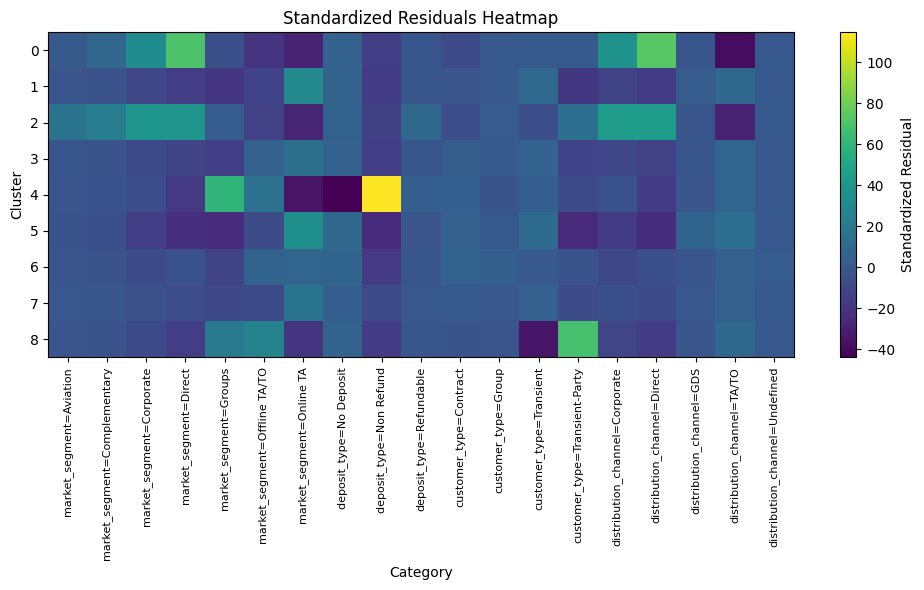

In [41]:
res_df = pd.concat(residuals, axis=1)  # MultiIndex: (variable, category)

plt.figure(figsize=(10, 6))
plt.imshow(res_df.values, aspect='auto')
plt.colorbar(label='Standardized Residual')

plt.xticks(
    range(res_df.shape[1]),
    [f"{var}={cat}" for var, cat in res_df.columns],
    rotation=90, fontsize=8
)
plt.yticks(range(res_df.shape[0]), res_df.index.astype(str))
plt.title('Standardized Residuals Heatmap')
plt.xlabel('Category')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()
